## CVMA (H) Image Transformations & Training Latent Spaces in Deep Convolutional Autoencoder Neural Networks 
### 2461352

<font color="red"> This exercise is my own work. </font>

In [1]:
## Standard imports
import numpy as np
import cv2
#from bitstring import Bits, BitArray, BitStream
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal
import skimage.morphology, skimage.transform, skimage.feature
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 6.0)

#standard utilities
def show_gray(img, title, **kwargs):
    plt.figure()
    plt.imshow(img, cmap="gray",  **kwargs)
    plt.axis("off")
    plt.title(title)

def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

### RGB/YIQ conversion code
yiq_mat =  np.array([[ 0.30, 0.59, 0.114],[0.599, 0.2773, 0.3217],[0.213,0.5251,0.3121]])
rgb_mat =  np.linalg.inv(yiq_mat)

def rgb_to_yiq(rgb):
    # RGB to YIQ
    return np.dot(rgb, yiq_mat)    
    
def yiq_to_rgb(yiq):
    # convert YIQ to RGB     
    return np.clip(np.dot(yiq,rgb_mat),0,1)

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
// this cell fixes the scroll boxes that are otherwise quite irritating

<IPython.core.display.Javascript object>

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()

torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")
print('Hardware Processing Device:', device)

Hardware Processing Device: cuda


## Utility functions

### Showing autoencoder images

In [4]:
def show_images(model, n_images=10, image_width=28):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=(20, 2.5))
    test_loader = torch.utils.data.DataLoader(dataset=datasets.FashionMNIST(root='data', 
                            train=False, 
                            transform=transforms.ToTensor(),
                            download=False), 
                            batch_size=n_images, 
                            shuffle=False)
    for (features, targets) in test_loader:
        features = features.to(device)
        orig_images = features[:n_images]
        decoded_images = model(features)[1][:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

In [5]:
def show_noisy_images(model, noise_fn, n_images=10, image_width=28):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=(20, 2.5))
    test_loader = torch.utils.data.DataLoader(dataset=datasets.FashionMNIST(root='data', 
                            train=False, 
                            transform=transforms.ToTensor(),
                            download=False), 
                            batch_size=n_images, 
                            shuffle=False)
    for (features, targets) in test_loader:
        noisy_features = noise_fn(features)
        noisy_features = noisy_features.to(device)
        features = features.to(device)
        orig_images = noisy_features[:n_images]
        decoded_images = model(noisy_features)[1][:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

### Plotting model loss and accuracy:

In [6]:
def plot_metrics(model_title, losses, accuracies=None):
    fig, ax = plt.subplots()
    num_epochs = len(losses)
    loss_plot, = ax.plot(range(1, num_epochs+1), losses, marker="o", color="b", label="Loss")
    ax.set_xlabel("Epoch")
    ax.set_xticks(range(1, num_epochs+1))
    ax.set_ylabel("Average test loss")


    if accuracies is not None:
        acc_ax = ax.twinx()
        acc_ax.set_ylim(min(accuracies) // 10 * 10, (max(accuracies) + 10) // 10 * 10)
        acc_ax.set_ylabel("Accuracy (%)")
        acc_plot, = acc_ax.plot(range(1, num_epochs+1), accuracies, marker="o", color="r", label="Accuracy")
        acc_ax.yaxis.label.set_color(acc_plot.get_color())
        ax.yaxis.label.set_color(loss_plot.get_color())
        ax.legend(handles=[loss_plot, acc_plot])
        plt.title(f"{model_title} accuracy and average test loss by epoch")
    else:
        plt.title(f"{model_title} average test loss by epoch")
    plt.show()

### Plotting compared model loss/accuracy

In [7]:
def plot_compared_loss(model_dict):
    fig, ax = plt.subplots()
    loss_plots = []
    for m in model_dict.keys():
        losses = model_dict[m]
        num_epochs = len(losses)
        loss_plot, = ax.plot(range(1, num_epochs+1), losses, marker="o", label=m)
        loss_plots.append(loss_plot)
    ax.set_xlabel("Epoch")
    ax.set_xticks(range(1, num_epochs+1))
    ax.set_ylabel("Test loss")
    ax.legend(handles=loss_plots)
    plt.title(f"Average test loss by model")
    plt.show()  

In [88]:
def plot_compared_accuracy(model_dict):
    fig, ax = plt.subplots()
    acc_plots = []
    for m in model_dict.keys():
        accs = model_dict[m]
        num_epochs = len(accs)
        acc_plot, = ax.plot(range(1, num_epochs+1), accs, marker="o", label=m)
        acc_plots.append(acc_plot)
    ax.set_xlabel("Epoch")
    ax.set_xticks(range(1, num_epochs+1))
    ax.set_ylabel("Test accuracy")
    ax.legend(handles=acc_plots)
    plt.title(f"Average test accuracy by model")
    plt.show()

### Plotting loss by parameter value

In [57]:
def plot_loss(param_name, param_dict):
    fig, ax = plt.subplots()
    loss_plots = []
    for v in param_dict.keys():
        losses = param_dict[v]
        num_epochs = len(losses)
        loss_plot, = ax.plot(range(1, num_epochs+1), losses, marker="o", label=v)
        loss_plots.append(loss_plot)
    ax.set_xlabel("Epoch")
    ax.set_xticks(range(1, num_epochs+1))
    ax.set_ylabel("Average test loss")
    ax.legend(handles=loss_plots)
    plt.title(f"Average test loss by {param_name}")
    plt.show()

### Parameter search algorithm

This function will search through a given dictionary of parameters, mapping parameter name to a list of values to try (not including the default values as these will be tried when running the original model) and sequentially optimise the model based on these parameters
This algorithm will:
   * Go through each parameter to be tried
   * For each parameter, save the lowest loss value (best parameter value) and use it while testing the next parameter
   * After each parameter, plot the losses for each parameter value (on one graph)
   * At the end, return the new best model, accuracies and losses, as well as a dictionary of the best parameters

In [58]:
def parameter_search(current_model, current_losses, current_hparams, current_baseline, param_dict, train_func, use_accuracy=True, current_accuracies=None):
    best_model = None
    best_losses = None
    best_accuracies = None
    best_hparams = current_hparams.copy()
    for param in param_dict.keys():
        param_losses = {}
        baseline = current_baseline
        if use_accuracy:
            print(f"Baseline accuracy: {baseline:0.2f}%")
        else:
            print(f"Baseline loss: {baseline:0.4f}")

        for value in param_dict[param]:
            # Train with parameter value
            current_hparams[param] = value
            if use_accuracy:
                model, losses, accuracies = train_func(current_hparams, silent=True)
                param_losses[value] = losses
                current_accuracy = accuracies[-1]
                print(f"Param {param}: Value {value} has Accuracy {current_accuracy:0.2f}")
                # Store as best parameter if it has the best accuracy so far
                if current_accuracy > current_baseline:
                    current_baseline = current_accuracy
                    best_accuracies = accuracies
                    best_losses = losses
                    best_hparams[param] = value
                    best_model = model
            else:
                model, losses = train_func(current_hparams, silent=True)
                param_losses[value] = losses
                current_loss = losses[-1]
                print(f"Param {param}: Value {value} has loss {current_loss:0.4f}")
                # Store as best parameter if it has the best accuracy so far
                if current_loss < current_baseline:
                    current_baseline = current_loss
                    best_hparams[param] = value
                    best_losses = losses
                    best_model = model
        # Use best parameter from now on
        current_hparams[param] = best_hparams[param]

        if use_accuracy:
            print(f"Best {param} value: {current_hparams[param]} with accuracy {current_baseline}%")
        else:
            print(f"Best {param} value: {current_hparams[param]} with loss {current_baseline:0.4f}")
        
        plot_loss(param, param_losses)
    
    if best_model is None:
        best_model = current_model
    if best_losses is None:
        best_losses = current_losses
    if use_accuracy and best_accuracies is None:
        best_accuracies = current_accuracies
        
    if use_accuracy:
        return (best_model, best_losses, best_accuracies, best_hparams)
    return (best_model, best_losses, best_hparams)

# Phase 1: Individual classifier and autoencoder

### Default model parameters

In [11]:
default_classifier_hparams = {
                              "learning_rate": 0.01,
                              "batch_size": 64,
                              "num_epochs": 10,
                              "dropout": 0.5,
                              "layers": "standard",
                              "pooling": "max",
                              "activation": "leaky_relu"}
default_encoder_hparams = {
                              "learning_rate": 0.005,
                              "batch_size": 128,
                              "num_epochs": 10,
                              "layers": "standard",
                              "pooling": "max",
                              "activation": "leaky_relu"}

## Baseline DCNN code for classifying the MNIST dataset:

### Baseline model

In [106]:
class Net(nn.Module):
    def __init__(self, hparams):

        poolings = {"max": F.max_pool2d,
                    "average": F.avg_pool2d,
                    "l2": lambda x,y: F.lp_pool2d(x, norm_type=2, kernel_size=y)}
        
        activations = {"leaky_relu": F.leaky_relu,
                       "relu":F.relu,
                       "sigmoid": F.sigmoid,
                       "tanh": F.tanh}

        self.dropout_p = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]

        self.layer_mod = hparams["layers"]


        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        self.conv_drop = nn.Dropout2d(p=self.dropout_p)

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.activation(self.pool(self.conv1(x), 2))
        x = self.activation(self.pool(self.conv_drop(self.conv2(x)), 2))

        x = x.view(-1, 320)
        x = self.activation(self.fc1(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Variation models (for parameter tuning)
Below are models with the following variations:
* Adding an extra convolutional layer
* Removing a convolutional layer
* Adding a fully connected layer
* Removing a fully connected layer

In [107]:
class Net_addconv(nn.Module):
    def __init__(self, hparams):

        poolings = {"max": F.max_pool2d,
                    "average": F.avg_pool2d,
                    "l2": lambda x,y: F.lp_pool2d(x, norm_type=2, kernel_size=y)}
        
        activations = {"leaky_relu": F.leaky_relu,
                       "relu":F.relu,
                       "sigmoid": F.sigmoid,
                       "tanh": F.tanh}

        self.dropout_p = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]

        self.layer_mod = hparams["layers"]


        super(Net_addconv, self).__init__()
        #28x28x1 -> 26x26x5
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3)
        #26x26x5 -> 24x24x10 -> 12x12x10
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3)
        #12x12x10 -> 8x8x20 -> 4x4x20
        self.conv3 = nn.Conv2d(10, 20, kernel_size=5)

        self.conv_drop = nn.Dropout2d(p=self.dropout_p)

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.pool(self.conv2(x), 2))
        x = self.activation(self.pool(self.conv_drop(self.conv3(x)), 2))

        x = x.view(-1, 320)
        x = self.activation(self.fc1(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [108]:
class Net_removeconv(nn.Module):
    def __init__(self, hparams):

        poolings = {"max": F.max_pool2d,
                    "average": F.avg_pool2d,
                    "l2": lambda x,y: F.lp_pool2d(x, norm_type=2, kernel_size=y)}
        
        activations = {"leaky_relu": F.leaky_relu,
                       "relu":F.relu,
                       "sigmoid": F.sigmoid,
                       "tanh": F.tanh}

        self.dropout_p = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]


        super(Net_removeconv, self).__init__()
        #28x28x1 -> 20x20x5 -> 10x10x5
        self.conv1 = nn.Conv2d(1, 5, kernel_size=9)

        self.conv_drop = nn.Dropout2d(p=self.dropout_p)

        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.activation(self.pool(self.conv_drop(self.conv1(x)), 2))

        x = x.view(-1, 500)
        x = self.activation(self.fc1(x))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [109]:
class Net_addconnected(nn.Module):
    def __init__(self, hparams):

        poolings = {"max": F.max_pool2d,
                    "average": F.avg_pool2d,
                    "l2": lambda x,y: F.lp_pool2d(x, norm_type=2, kernel_size=y)}
        
        activations = {"leaky_relu": F.leaky_relu,
                       "relu": F.relu,
                       "sigmoid": F.sigmoid,
                       "tanh": F.tanh}

        self.dropout_p = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]

        self.layer_mod = hparams["layers"]
        super(Net_addconnected, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        self.conv_drop = nn.Dropout2d(p=self.dropout_p)

        self.fc1 = nn.Linear(320, 80)
        self.fc2 = nn.Linear(80, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.activation(self.pool(self.conv1(x), 2))
        x = self.activation(self.pool(self.conv_drop(self.conv2(x)), 2))

        x = x.view(-1, 320)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [110]:
class Net_removeconnected(nn.Module):
    def __init__(self, hparams):

        poolings = {"max": F.max_pool2d,
                    "average": F.avg_pool2d,
                    "l2": lambda x,y: F.lp_pool2d(x, norm_type=2, kernel_size=y)}
        
        activations = {"leaky_relu": F.leaky_relu,
                       "relu":F.relu,
                       "sigmoid": F.sigmoid,
                       "tanh": F.tanh}

        self.dropout_p = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]

        self.layer_mod = hparams["layers"]
        super(Net_removeconnected, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        self.conv_drop = nn.Dropout2d(p=self.dropout_p)

        self.fc1 = nn.Linear(320, 10)

    def forward(self, x):
        x = self.activation(self.pool(self.conv1(x), 2))
        x = self.activation(self.pool(self.conv_drop(self.conv2(x)), 2))

        x = x.view(-1, 320)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

### Preparing to train classifier

Functions based on the given code which will run the models using hyperparameters given in the "hparams" argument. It will output the trained model, a list of losses per epoch and a list of test accuracies per epoch

In [17]:
def classifier_epoch(model, device, train_loader, optimizer, epoch, silent=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if not silent and batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_classifier(model, device, test_loader, silent=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = (100. * correct / len(test_loader.dataset))
    if not silent:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          accuracy))
    return test_loss, accuracy


def train_classifier(hparams, silent=False):
    num_epochs = hparams["num_epochs"]
    batch_size = hparams["batch_size"]
    learning_rate = hparams["learning_rate"]

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=False, download=True, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
        batch_size=1000, shuffle=True, **kwargs)

    models = {"standard": Net,
            "add_conv": Net_addconv,
            "remove_conv": Net_removeconv,
            "add_connected": Net_addconnected,
            "remove_connected": Net_removeconnected}

    model = models[hparams["layers"]](hparams).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(1, num_epochs + 1):
        classifier_epoch(model, device, train_loader, optimizer, epoch, silent=silent)
        epoch_loss, epoch_accuracy = test_classifier(model, device, test_loader, silent=silent)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

    return (model, epoch_losses, epoch_accuracies)

## Baseline DCNN code for autoencoding the MNIST dataset:

### Baseline model

In [18]:
class ConvolutionalAutoencoder(torch.nn.Module):
    def __init__(self, hparams):
        super(ConvolutionalAutoencoder, self).__init__()

        poolings = {"max": torch.nn.MaxPool2d,
                    "average": torch.nn.AvgPool2d,
                   "l2": lambda x,y: torch.nn.LPPool2d(2, x, y)}
        
        activations = {"leaky_relu": F.leaky_relu,
                       "relu":F.relu,
                       "sigmoid": F.sigmoid,
                       "tanh": F.tanh}
        
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 28x28x1 => 28x28x4
        self.conv_1 = nn.Conv2d(in_channels=1,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1) 
        # 28x28x4 => 14x14x4                              
        self.pool_1 = self.pool((2, 2), (2, 2))                                       
        # 14x14x4 => 14x14x8
        self.conv_2 = nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)                 
        # 14x14x8 => 7x7x8                             
        self.pool_2 = self.pool((2, 2), (2, 2))
        
        ### DECODER
                                         
        # 7x7x8 => 15x15x4                          
        self.deconv_1 = nn.ConvTranspose2d(in_channels=8,
                                                 out_channels=4,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
        
        # 15x15x4  => 31x31x1                           
        self.deconv_2 = nn.ConvTranspose2d(in_channels=4,
                                                 out_channels=1,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
        
    def forward(self, x):

        ### ENCODER
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.activation(x)
        x = self.pool_2(x)

        ### DECODER
        x = self.deconv_1(x)
        x = self.activation(x)
        x = self.deconv_2(x)
        x = self.activation(x)
        logits = x[:, :, 2:30, 2:30]
        probas = torch.sigmoid(logits)
        return logits, probas

### Variation models (for parameter tuning)
Below are models with the following variations:
* Adding an extra convolutional layer
* Removing a convolutional layer

In [19]:
class ConvolutionalAutoencoder_addconv(torch.nn.Module):
    def __init__(self, hparams):
        super(ConvolutionalAutoencoder_addconv, self).__init__()

        poolings = {"max": nn.MaxPool2d,
                    "average": nn.AvgPool2d,
                    "l2": lambda x,y: nn.LPPool2d(2, x, y)}
        
        activations = {"leaky_relu": F.leaky_relu,
                       "relu":F.relu,
                       "sigmoid": F.sigmoid,
                       "tanh": F.tanh}

        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 28x28x1 => 28x28x2
        self.conv_1 = nn.Conv2d(in_channels=1,
                                      out_channels=2,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1) 
        # 28x28x2 => 14x14x2                              
        self.pool_1 = self.pool((2, 2), (2, 2))                                       
        # 14x14x2 => 14x14x4
        self.conv_2 = nn.Conv2d(in_channels=2,
                                      out_channels=4,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(14-1) - 14 + 3) / 2 = 1
                                      padding=1)                 
        # 14x14x4 => 7x7x4                             
        self.pool_2 = self.pool((2, 2), (2, 2))

        # 7x7x4 => 7x7x8
        self.conv_3 = nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      # (1(7-1) - 7 + 3) / 2 = 1
                                      padding=1)                  

        ### DECODER
                                         
        # 7x7x8 => 15x15x4                          
        self.deconv_1 = nn.ConvTranspose2d(in_channels=8,
                                                 out_channels=4,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
        
        # 15x15x4  => 31x31x1                           
        self.deconv_2 = nn.ConvTranspose2d(in_channels=4,
                                                 out_channels=1,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
        
    def forward(self, x):
        
        ### ENCODER
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.activation(x)
        x = self.pool_2(x)
        x = self.conv_3(x)

        ### DECODER
        x = self.deconv_1(x)
        x = self.activation(x)
        x = self.deconv_2(x)
        x = self.activation(x)
        logits = x[:, :, 2:30, 2:30]
        probas = torch.sigmoid(logits)
        return logits, probas

In [20]:
class ConvolutionalAutoencoder_removeconv(torch.nn.Module):
    def __init__(self, hparams):
        super(ConvolutionalAutoencoder_removeconv, self).__init__()

        poolings = {"max": nn.MaxPool2d,
                    "average": nn.AvgPool2d,
                    "l2": lambda x,y: nn.LPPool2d(2, x, y)}
        
        activations = {"leaky_relu": F.leaky_relu,
                       "relu":F.relu,
                       "sigmoid": F.sigmoid,
                       "tanh": F.tanh}

        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        ### ENCODER
        
        # 28x28x1 => 14x14x8
        self.conv_1 = nn.Conv2d(in_channels=1,
                                      out_channels=8,
                                      kernel_size=(4, 4),
                                      stride=(2, 2),
                                      # (1(28-1) - 28 + 3) / 2 = 1
                                      padding=1) 
        # 14x14x8 => 7x7x8                              
        self.pool_1 = self.pool((2, 2), (2, 2))                                       
        
        ### DECODER
                                         
        # 7x7x8 => 15x15x4                          
        self.deconv_1 = nn.ConvTranspose2d(in_channels=8,
                                                 out_channels=4,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)
        
        # 15x15x4  => 31x31x1                           
        self.deconv_2 = nn.ConvTranspose2d(in_channels=4,
                                                 out_channels=1,
                                                 kernel_size=(3, 3),
                                                 stride=(2, 2),
                                                 padding=0)

    def forward(self, x):
        
        ### ENCODER
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.pool_1(x)
        
        ### DECODER
        x = self.deconv_1(x)
        x = self.activation(x)
        x = self.deconv_2(x)
        x = self.activation(x)
        logits = x[:, :, 2:30, 2:30]
        probas = torch.sigmoid(logits)
        return logits, probas

### Preparing to train autoencoder

This function works similarly to the classifier one, but does not return a list of accuracies

In [21]:
def encoder_epoch(model, device, train_loader, optimizer, epoch, silent=False):
    for batch_idx, (features, targets) in enumerate(train_loader):
        # don't need labels, only the images (features)
        features = features.to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        logits, decoded = model(features)
        loss = F.mse_loss(decoded, features)
        optimizer.zero_grad()

        loss.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not silent and batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(features), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_encoder(model, device, test_loader, silent=False):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            logits, decoded = model(features)
            test_loss += F.mse_loss(decoded, features) # sum up batch loss
    test_loss /= len(test_loader)
    if not silent:
        print('\nTest set: Average loss: {:.4f}\n'.format(
          test_loss))
    return test_loss.item()

def train_encoder(hparams, silent=False):
    num_epochs = hparams["num_epochs"]
    batch_size = hparams["batch_size"]
    learning_rate = hparams["learning_rate"]

    train_loader = torch.utils.data.DataLoader(dataset=datasets.FashionMNIST(root='data', 
                                train=True, 
                                transform=transforms.ToTensor(),
                                download=True), 
                            batch_size=batch_size, 
                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=datasets.FashionMNIST(root='data', 
                                train=False, 
                                transform=transforms.ToTensor(),
                                download=True), 
                            batch_size=batch_size, 
                            shuffle=False)

    models = {"standard": ConvolutionalAutoencoder,
            "add_conv": ConvolutionalAutoencoder_removeconv,
            "remove_conv": ConvolutionalAutoencoder_addconv}

    model = models[hparams["layers"]](hparams).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch_losses = []

    for epoch in range(1, num_epochs + 1):
        encoder_epoch(model, device, train_loader, optimizer, epoch, silent=silent)
        epoch_loss = test_encoder(model, device, test_loader, silent=silent)
        epoch_losses.append(epoch_loss)
    return (model, epoch_losses)

## 1-2: Training

In [22]:
classifier_base_model, classifier_losses, classifier_accuracies = train_classifier(default_classifier_hparams, silent=True)
print(f"Standard classifier accuracy: {classifier_accuracies[-1]:0.2f}%")
print(f"Standard classifier average loss: {classifier_losses[-1]:0.4f}")

Standard classifier accuracy: 84.88%
Standard classifier average loss: 0.4046


In [23]:
encoder_base_model, encoder_losses = train_encoder(default_encoder_hparams, silent=True)
print(f"Standard encoder average loss: {encoder_losses[-1]:0.4f}")

Standard encoder average loss: 0.0112


### Autoencoder image transformations

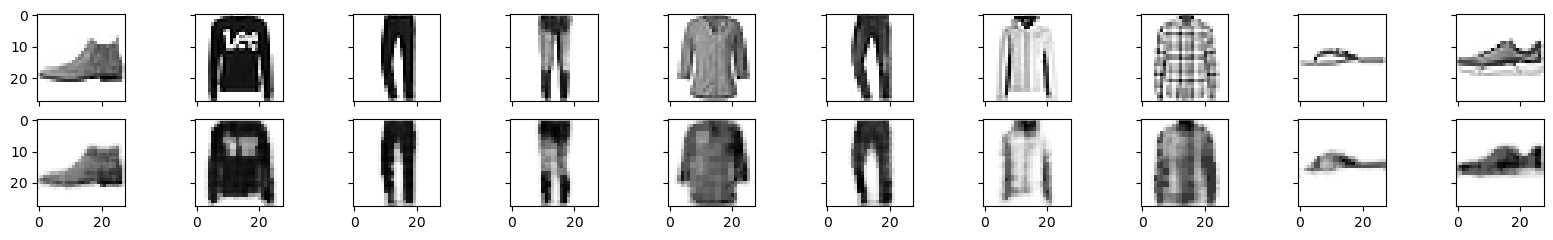

In [24]:
show_images(encoder_base_model)

### 3: Classifier and autoencoder accuracy/loss

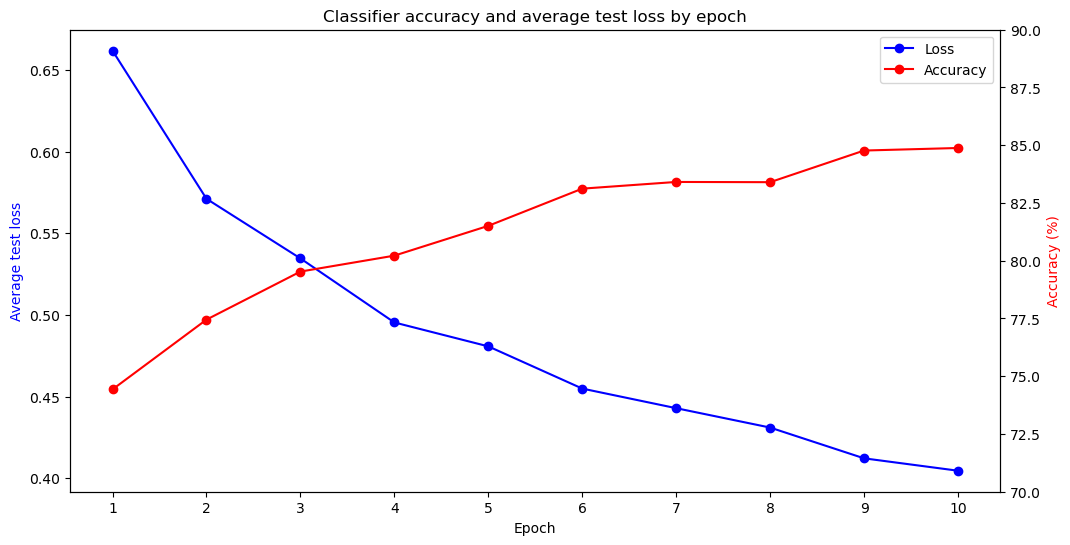

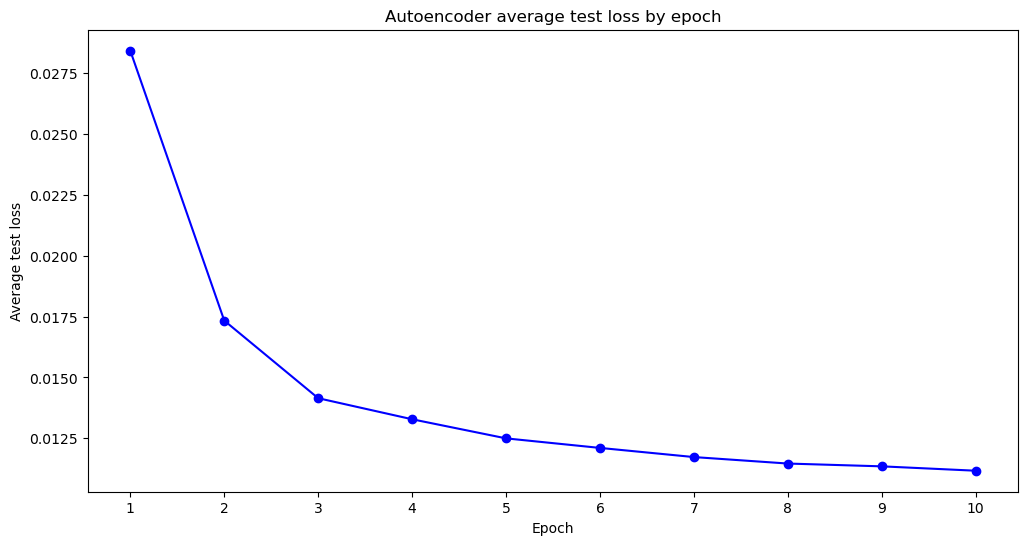

In [25]:
plot_metrics("Classifier", classifier_losses, classifier_accuracies)
print("\n\n\n")
plot_metrics("Autoencoder", encoder_losses)

We can see that the models are clearly learning, especially after the first few epochs, where the model initially is randomised and has no clue how to solve the problem (classify/decode). As the model becomes better, its loss decreases / accuracy increases less quickly, as it is learning less each time and instead finetuning its parameters

## 4: Parameter optimisation

I will experiment with and optimise different values of:

* **Model type**: In both models, I will test the performance when adding or removing a convolution layer. This is to see if more parameters are needed to create a network capable of performing the given task, or if perhaps the models have too many parameters which is leading to worse performance through overfitting. For the classifier I will also try adding and removing a fully connected layer.
* **Batch size**: I will try sizes 16, 32, 64 (baseline) and 128 for the classifier, and sizes 16, 64, 128 (baseline) and 256 for the autoencoder.
* **Number of epochs**: I would like to see how much performance can be gained for running the training for more than 10 epochs, and how much is lost when only running for half the epochs. For both models I will try 5, 10 (baseline), 15 and 20 epochs.
* **Dropout level**: By default, the dropout layers zero out half (p=0.5) of parameters. I will investigate performance when instead using p=0.3 (30% dropout), p=0.7 (70%) and p=0.9 (90%).
* **Pooling types**: By default, the models use 2x2 max pooling (reduce the layer by taking only the maximum of each 2x2 subimage). I will also investigate average pooling (instead taking the average) and L2 pulling (taking the L2 norm)
* **Activation functions**: Currently the models use leaky ReLU, I will experiment the effectiveness of standard ReLU (no negative values allowed) and other common network activation functions sigmoid and tanh

### Optimising classifier

Baseline accuracy: 84.88%
Param layers: Value add_conv has Accuracy 84.19
Param layers: Value remove_conv has Accuracy 82.68
Param layers: Value add_connected has Accuracy 85.91
Param layers: Value remove_connected has Accuracy 87.33
Best layers value: remove_connected with accuracy 87.33%


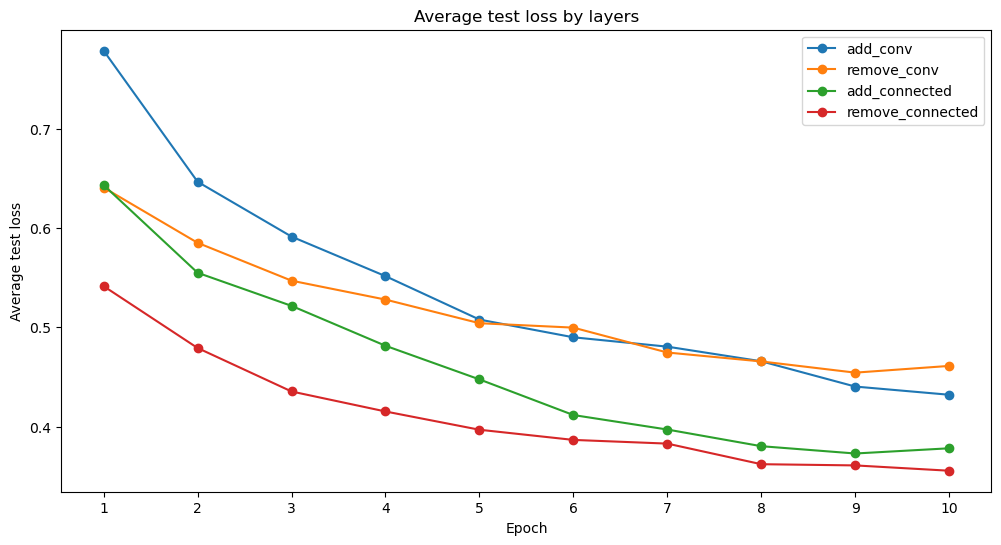

Baseline accuracy: 87.33%
Param batch_size: Value 16 has Accuracy 87.69
Param batch_size: Value 32 has Accuracy 87.54
Param batch_size: Value 128 has Accuracy 86.11
Best batch_size value: 16 with accuracy 87.69%


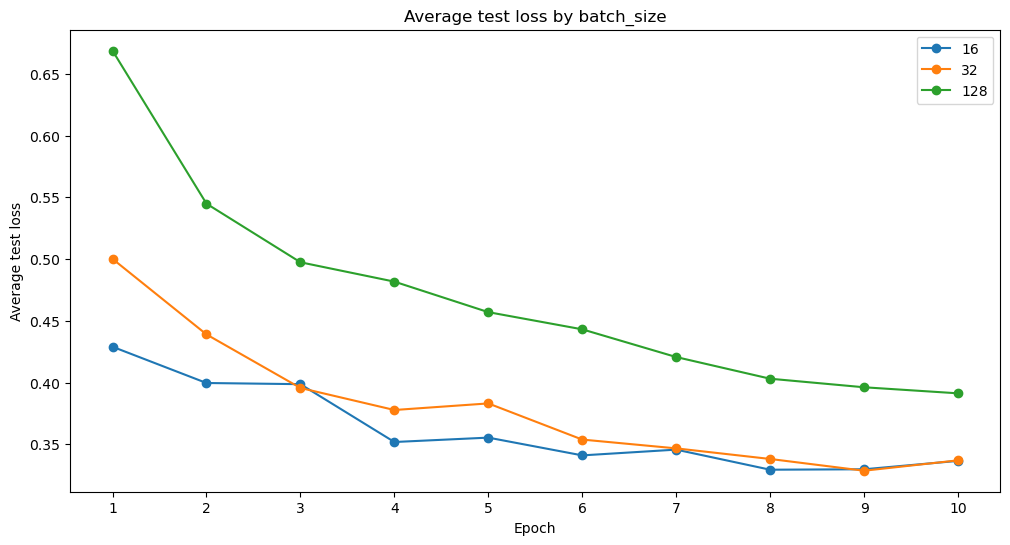

Baseline accuracy: 87.69%
Param num_epochs: Value 5 has Accuracy 87.72
Param num_epochs: Value 15 has Accuracy 88.36
Param num_epochs: Value 20 has Accuracy 87.84
Best num_epochs value: 15 with accuracy 88.36%


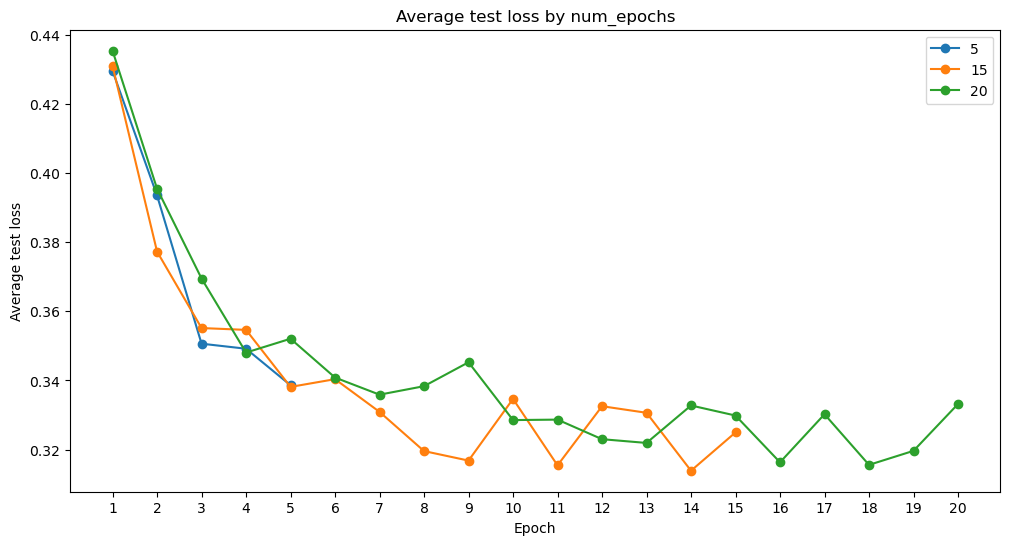

Baseline accuracy: 88.36%
Param dropout: Value 0.3 has Accuracy 89.14
Param dropout: Value 0.7 has Accuracy 87.55
Param dropout: Value 0.9 has Accuracy 83.73
Best dropout value: 0.3 with accuracy 89.14%


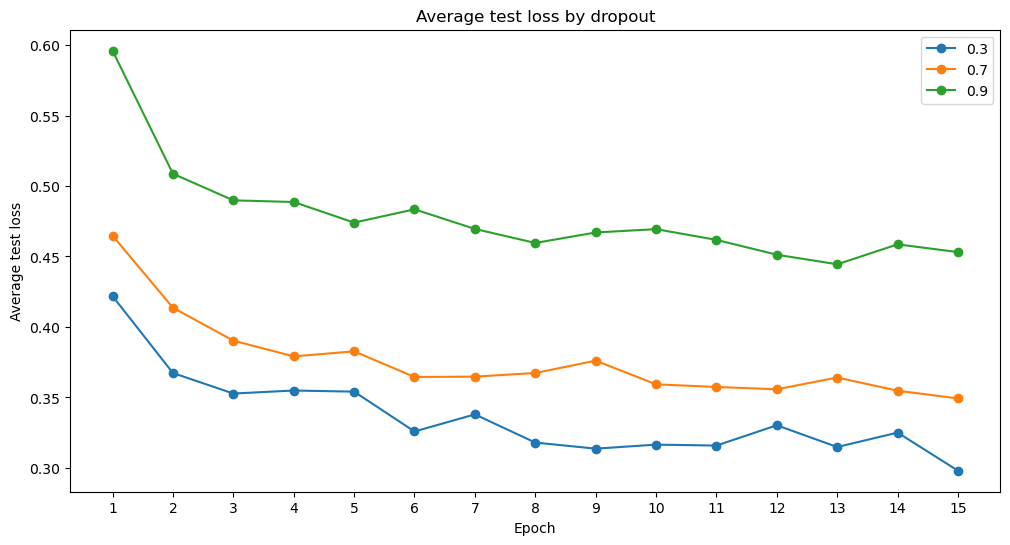

Baseline accuracy: 89.14%
Param pooling: Value average has Accuracy 88.45
Param pooling: Value l2 has Accuracy 85.74
Best pooling value: max with accuracy 89.14%


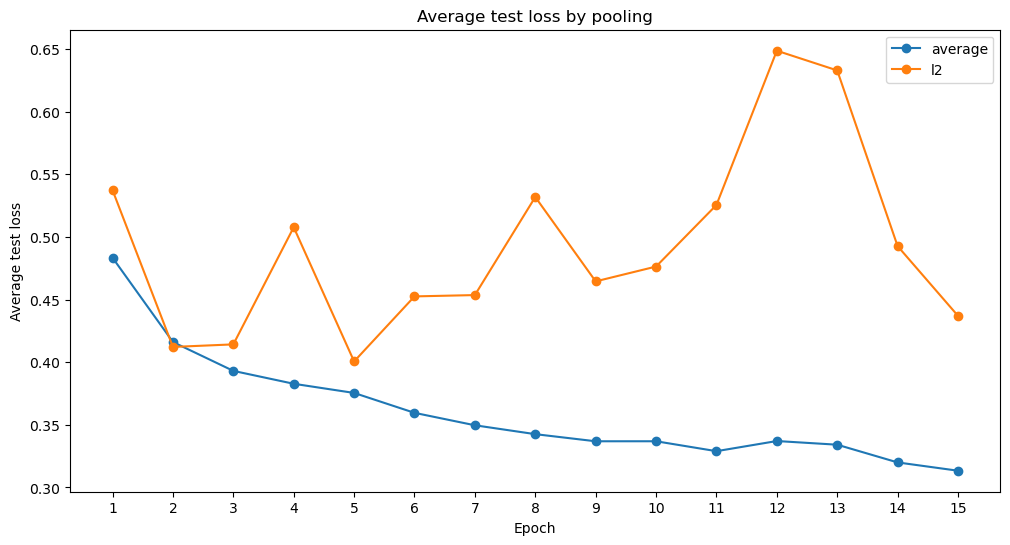

Baseline accuracy: 89.14%
Param activation: Value relu has Accuracy 88.92


D:\Users\Adam\anaconda3\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Param activation: Value sigmoid has Accuracy 85.62


D:\Users\Adam\anaconda3\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Param activation: Value tanh has Accuracy 89.33
Best activation value: tanh with accuracy 89.33%


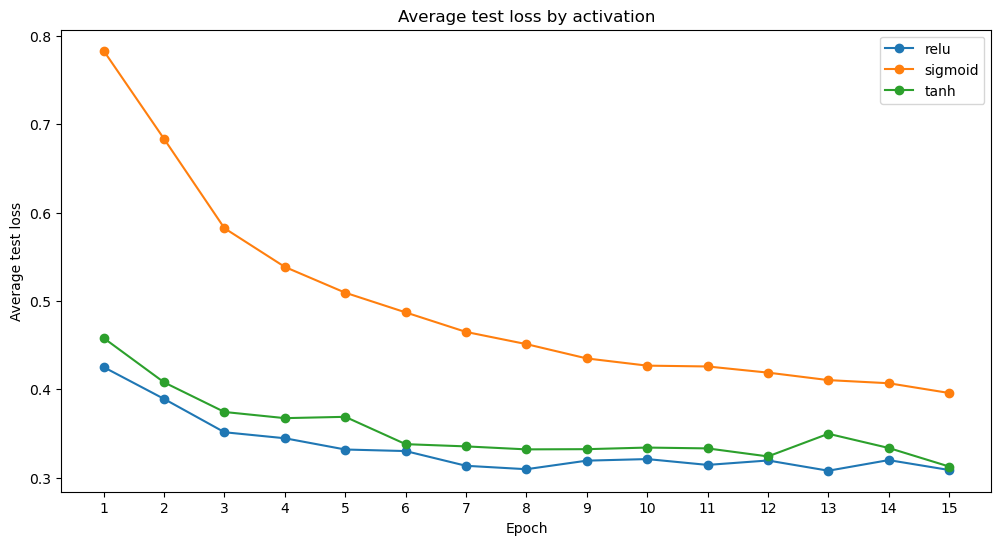

{'learning_rate': 0.01, 'batch_size': 16, 'num_epochs': 15, 'dropout': 0.3, 'layers': 'remove_connected', 'pooling': 'max', 'activation': 'tanh'}


In [59]:
current_hparams = default_classifier_hparams.copy()
layers = ["add_conv", "remove_conv", "add_connected", "remove_connected"]
batch_sizes = [16, 32, 128]
num_epochs = [5, 15, 20]
drop_outs = [0.3, 0.7, 0.9]
poolings = ["average", "l2"]
activations = ["relu", "sigmoid", "tanh"]

classifier_hparams = {"layers": layers,
          "batch_size": batch_sizes,
          "num_epochs": num_epochs,
          "dropout": drop_outs,
          "pooling": poolings,
          "activation": activations}

baseline_accuracy = classifier_accuracies[-1]

classifier_best_model, classifier_best_losses, classifier_best_accuracies, best_classifier_hparams = parameter_search(classifier_base_model, classifier_losses, current_hparams, baseline_accuracy, classifier_hparams, train_classifier, True, classifier_accuracies)
print(best_classifier_hparams)

#### Best parameters found:
   * Best model variant: *Removed connected layer*
   * Best batch size: *16*
   * Best number of epochs: *15*
   * Best dropout level: *0.3*
   * Best pooling type: *Max*
   * Best activation function: *tanh*

### Optimising Autoencoder

Baseline loss: 0.0112
Param layers: Value add_conv has loss 0.0153
Param layers: Value remove_conv has loss 0.0139
Best layers value: standard with loss 0.0112


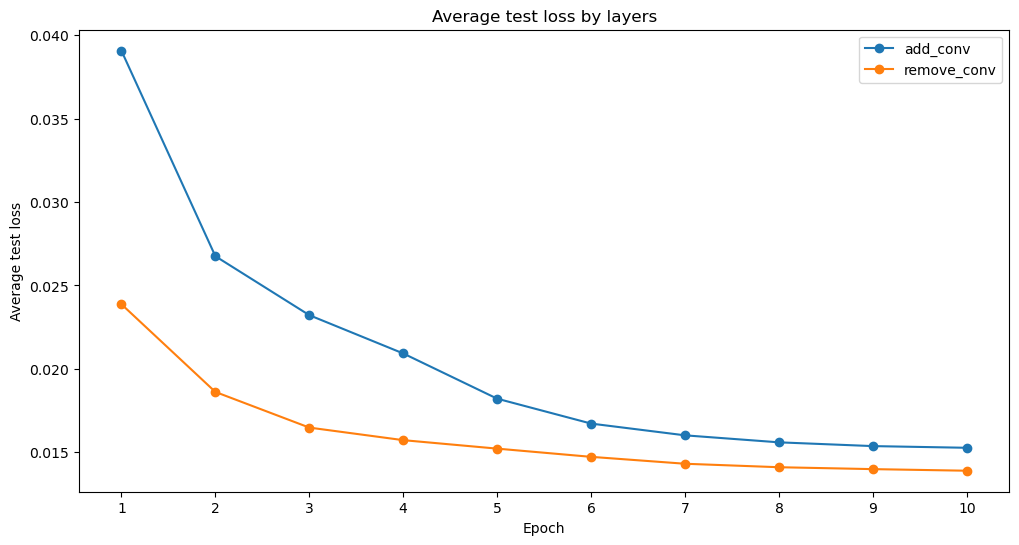

Baseline loss: 0.0112
Param batch_size: Value 16 has loss 0.0210
Param batch_size: Value 64 has loss 0.0146
Param batch_size: Value 256 has loss 0.0221
Best batch_size value: 128 with loss 0.0112


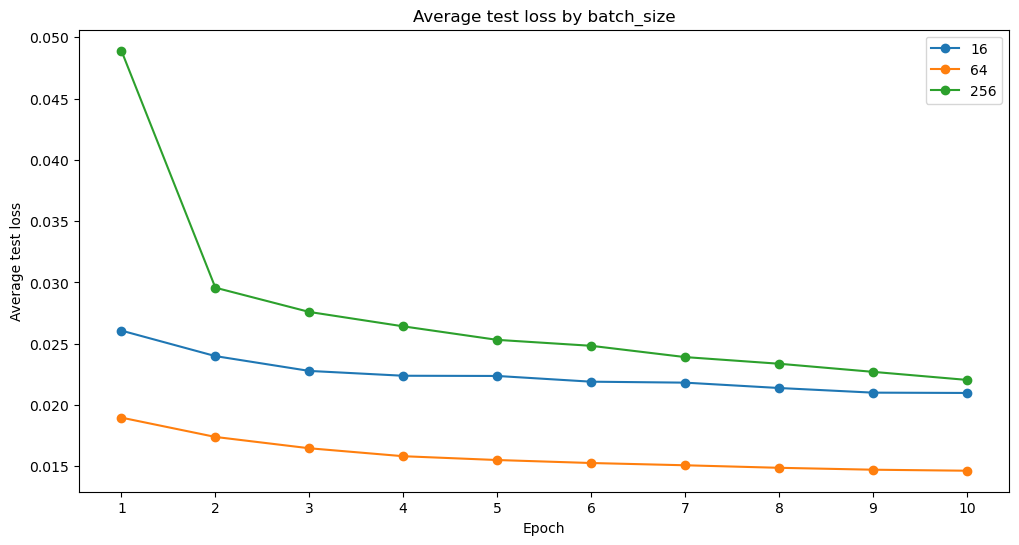

Baseline loss: 0.0112
Param num_epochs: Value 5 has loss 0.0130
Param num_epochs: Value 15 has loss 0.0109
Param num_epochs: Value 20 has loss 0.0250
Best num_epochs value: 15 with loss 0.0109


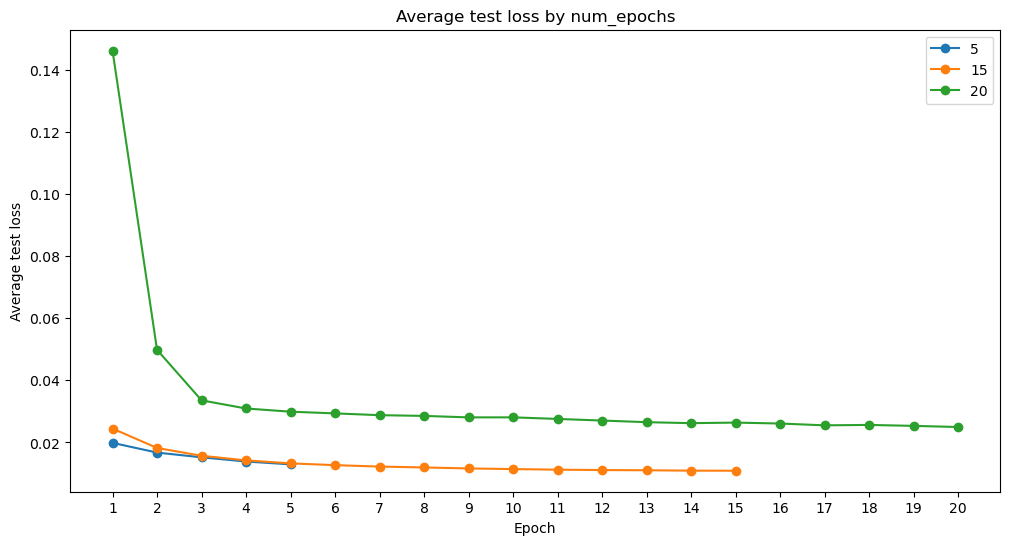

Baseline loss: 0.0109
Param pooling: Value average has loss 0.0104
Param pooling: Value l2 has loss 0.0103
Best pooling value: l2 with loss 0.0103


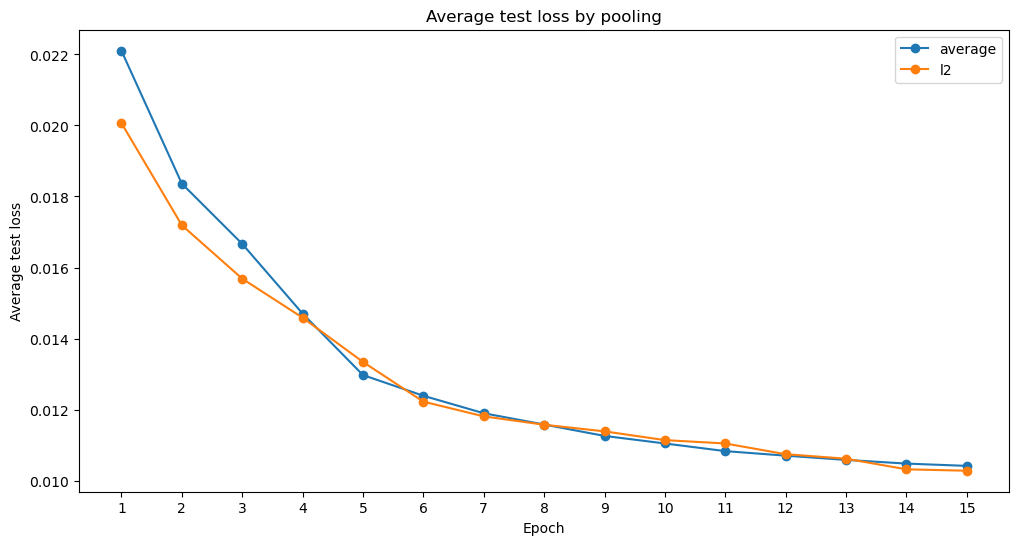

Baseline loss: 0.0103
Param activation: Value relu has loss 0.1509
Param activation: Value sigmoid has loss 0.1698
Param activation: Value tanh has loss 0.0477
Best activation value: leaky_relu with loss 0.0103


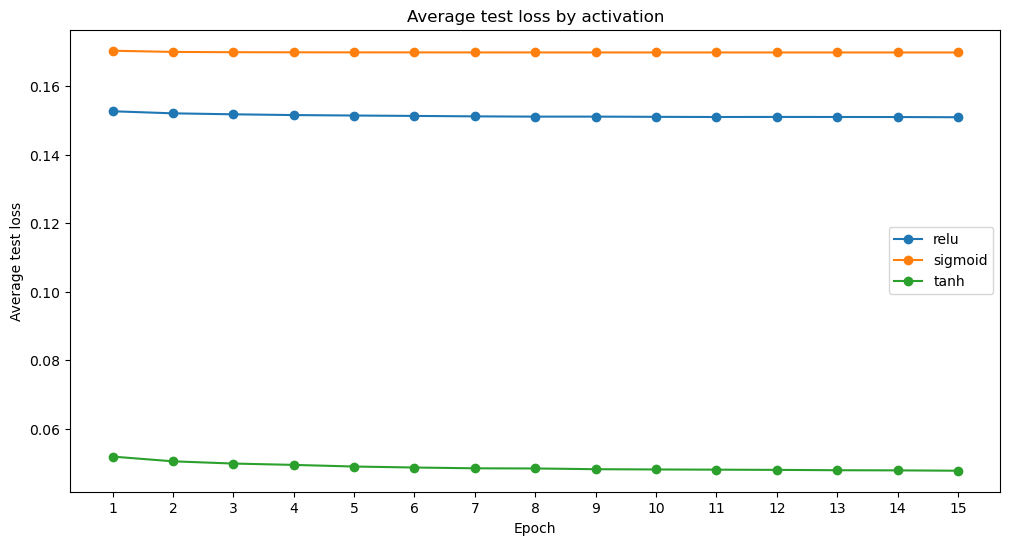

{'learning_rate': 0.005, 'batch_size': 128, 'num_epochs': 15, 'layers': 'standard', 'pooling': 'l2', 'activation': 'leaky_relu'}


In [62]:
current_encoder_hparams = default_encoder_hparams.copy()

layers = ["add_conv", "remove_conv"]
batch_sizes = [16, 64, 256]
num_epochs = [5, 15, 20]
poolings = ["average", "l2"]
activations = ["relu", "sigmoid", "tanh"]

encoder_hparams = {"layers": layers,
          "batch_size": batch_sizes,
          "num_epochs": num_epochs,
          "pooling": poolings,
          "activation": activations}


baseline_loss = encoder_losses[-1]

encoder_best_model, encoder_best_losses, best_encoder_hparams = parameter_search(encoder_base_model, encoder_losses, current_encoder_hparams, baseline_loss, encoder_hparams, train_encoder, False)
print(best_encoder_hparams)

#### Best parameters found:
   * Best model variant: *Standard*
   * Best batch size: *128*
   * Best number of epochs: *15*
   * Best pooling type: *L2 Norm*
   * Best activation function: *Leaky ReLU*

## Results

### Optimised autoencoder image transformations

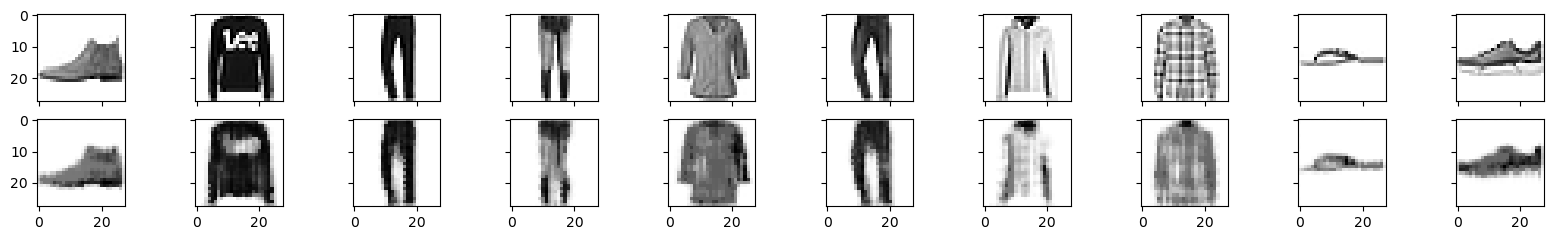

In [66]:
# Show optimised model images
show_images(encoder_best_model)

### Best classifier model

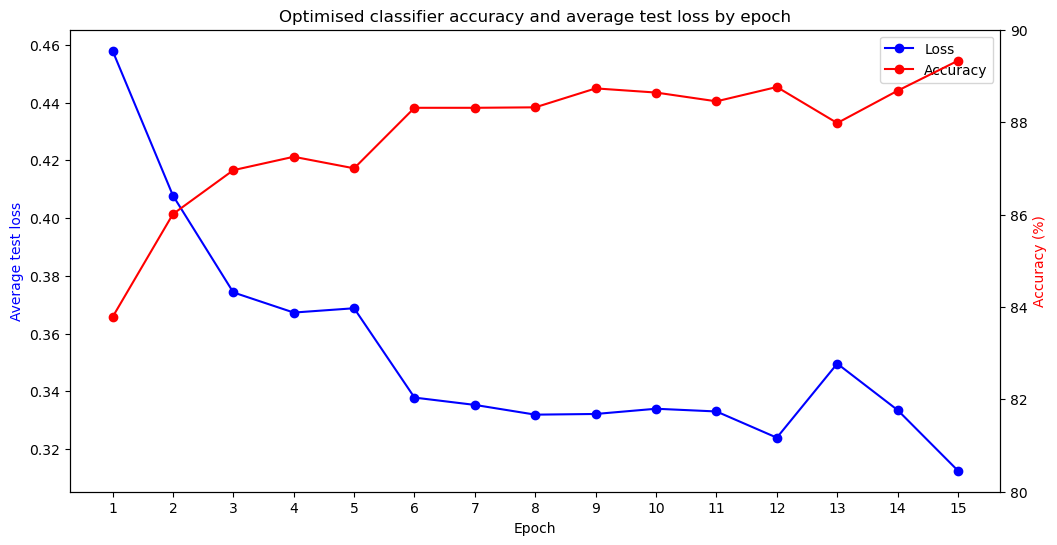

In [61]:
# Base and best model accuracies and losses
plot_metrics("Optimised classifier", classifier_best_losses, classifier_best_accuracies)

### Best encoder model

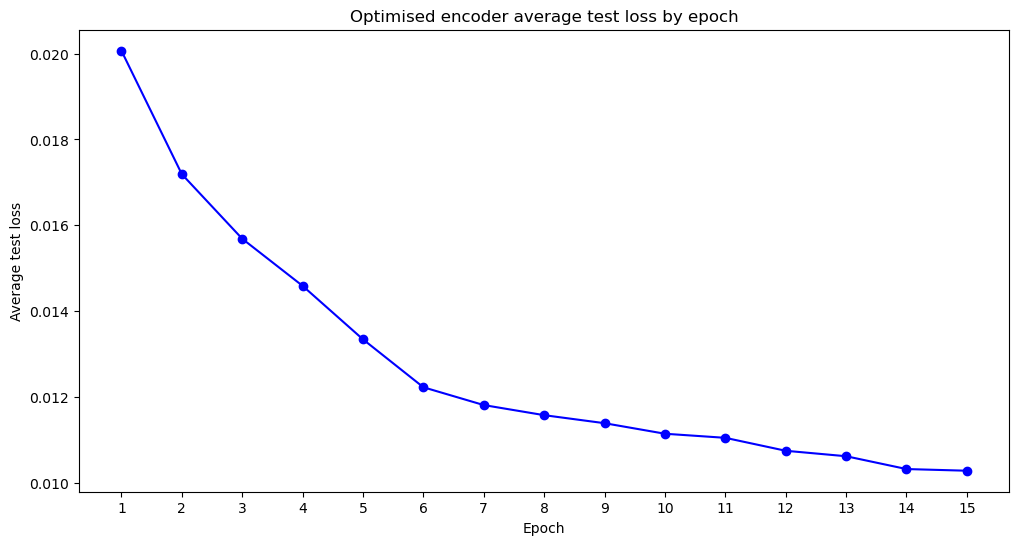

In [67]:
# Base and best model accuracies and losses
plot_metrics("Optimised encoder", encoder_best_losses)

## Interpretation

Sequentially optimising each parameter yielded an accuracy increase of 4.45% (from 84.88% to 89.33%) in the classifier and a loss decrease of 8.04% (0.112 to 0.103) in the autoencoder. This shows the importance of testing parameters as we can't know beforehand which ones will complete the task more effectively. In particular, (explain better params) 

It is interesting to note that after 9 epochs, the losses vary a lot, beginning to increase. This could be because the learning rate is causing the model to learn too quickly and cannot fit to the task more specifically than after 9 epochs, and instead oscillates aorund the best solution.

Due to time constraints, these parameters are searched sequentially, improving greedily at every new parameter optimised, but a grid search would be more effective as some parameter values may impact the performance of other parameter values.

# Phase 2: Combining models

I added the encoder layers of the previous model and wrapped them up in an encoder transformation, which will only perform the encoding part of the autoecoder model. I then wrapped up the classification and decoding parts of the previous classifier and autoencoder models respectively into their own transformation. When the model is training, it will now: 
   * Encode the input image using the encoder transformation
   * Decode the encoded input image as before in the autoencoder, using the decoder transformation
   * It will also flatten the encoded output and classify it (through the classifier transformation)
   * It will return as output both the classification and the decoded image, for use in a combined loss function

### Default model parameters

In [32]:
default_combined_hparams = {
                            "learning_rate": 0.005,
                            "batch_size": 64,
                            "num_epochs": 10,
                            "dropout": 0.5,
                            "layers": "standard",
                            "pooling": "max",
                            "activation": "leaky_relu",
                            "gamma": 0.5
                            }

### 1 A-D: Baseline combined model

In [33]:
class Combined(torch.nn.Module):
    def __init__(self, hparams):
        super(Combined, self).__init__()

        poolings = {"max": torch.nn.MaxPool2d,
                    "average": nn.AvgPool2d,
                   "l2": lambda x,y: nn.LPPool2d(2, x, y)}
        
        activations = {"leaky_relu": nn.LeakyReLU,
                       "relu":nn.ReLU,
                       "sigmoid": nn.Sigmoid,
                       "tanh": nn.Tanh}
    
        self.dropout = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), stride=(1, 1),padding=1),
            self.activation(),
            self.pool((2,2), (2,2)),
            torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=1),
            self.activation(),
            self.pool((2,2), (2,2))
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=(3, 3), stride=(2, 2), padding=0),
            self.activation(),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=(3, 3), stride=(2, 2), padding=0),
            self.activation()
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(392, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(-1, 392)
        classified = self.classifier(encoded)
        probas = torch.sigmoid(decoded[:, :, 2:30, 2:30])
        return (classified, probas)

### Variation models (for parameter tuning)
Below are models with the following variations:
* Adding an extra convolutional layer
* Removing a convolutional layer
* Adding a fully connected layer

In [69]:
class Combined_addconv(torch.nn.Module):
    def __init__(self, hparams):
        super(Combined_addconv, self).__init__()

        poolings = {"max": torch.nn.MaxPool2d,
                    "average": nn.AvgPool2d,
                   "l2": lambda x,y: nn.LPPool2d(2, x, y)}
        
        activations = {"leaky_relu": nn.LeakyReLU,
                       "relu":nn.ReLU,
                       "sigmoid": nn.Sigmoid,
                       "tanh": nn.Tanh}
    
        self.dropout = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]  
        
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3, 3), stride=(1, 1),padding=1),
            self.activation(),
            self.pool((2,2), (2,2)),
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3, 3), stride=(1, 1), padding=1),
            self.pool((2,2), (2,2)),
            torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=1),
            self.activation()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=(3, 3), stride=(2, 2), padding=0),
            self.activation(),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=(3, 3), stride=(2, 2), padding=0),
            self.activation()
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(392, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(-1, 392)
        classified = self.classifier(encoded)
        probas = torch.sigmoid(decoded[:, :, 2:30, 2:30])
        return (classified, probas)

In [35]:
class Combined_removeconv(torch.nn.Module):
    def __init__(self, hparams):
        super(Combined_removeconv, self).__init__()

        poolings = {"max": torch.nn.MaxPool2d,
                    "average": nn.AvgPool2d,
                   "l2": lambda x,y: nn.LPPool2d(2, x, y)}
        
        activations = {"leaky_relu": nn.LeakyReLU,
                       "relu":nn.ReLU,
                       "sigmoid": nn.Sigmoid,
                       "tanh": nn.Tanh}
    
        self.dropout = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]  

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(4, 4), stride=(2, 2), padding=1),
            self.activation(),
            self.pool((2,2), (2,2))
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=(3, 3), stride=(2, 2), padding=0),
            self.activation(),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=(3, 3), stride=(2, 2), padding=0),
            self.activation()
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(392, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(-1, 392)
        classified = self.classifier(encoded)
        probas = torch.sigmoid(decoded[:, :, 2:30, 2:30])
        return (classified, probas)

In [36]:
class Combined_addconnected(torch.nn.Module):
    def __init__(self, hparams):
        super(Combined_addconnected, self).__init__()

        poolings = {"max": torch.nn.MaxPool2d,
                    "average": nn.AvgPool2d,
                   "l2": lambda x,y: nn.LPPool2d(2, x, y)}
        
        activations = {"leaky_relu": nn.LeakyReLU,
                       "relu":nn.ReLU,
                       "sigmoid": nn.Sigmoid,
                       "tanh": nn.Tanh}
    
        self.dropout = hparams["dropout"]
        self.pool = poolings[hparams["pooling"]]
        self.activation = activations[hparams["activation"]]
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), stride=(1, 1),padding=1),
            self.activation(),
            self.pool((2,2), (2,2)),
            torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=1),
            self.activation(),
            self.pool((2,2), (2,2))
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=(3, 3), stride=(2, 2), padding=0),
            self.activation(),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=(3, 3), stride=(2, 2), padding=0),
            self.activation()
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(392, 64),
            nn.Linear(64,10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        encoded = encoded.view(-1, 392)
        classified = self.classifier(encoded)
        probas = torch.sigmoid(decoded[:, :, 2:30, 2:30])
        return (classified, probas)

### Preparing to train combined model

#### 1E-G: Combined loss function:
The original classifier uses negative log likelihood loss (maximises likelihood of model choosing the correct fashion item for the training images) and the autoencoder uses mean squared error loss to compare the original and decoded images. I will introduce a parameter γ for the combined model, which signifies how much of the combined loss comes from the autoencoder (0 <= γ <= 1). The combined loss is therefore calculated as γ * decoder loss + (1-γ) * classifier loss. This means at γ=0 the network is purely a classifier and at γ=1 the network is purely an autoencoder.

In [37]:
# Set default values
c_mean = 0.0
c_stdev = 1.0
d_mean = 0.0
d_stdev = 1.0

In [38]:
def combined_loss(c, d, features, targets, gamma):
    c_loss = F.nll_loss(c, targets)   
    d_loss = F.mse_loss(d, features)
    # Normalise c_loss and d_loss
    c_loss -= c_mean
    c_loss /= c_stdev
    d_loss -= d_mean
    d_loss /= d_stdev
    return (gamma * d_loss) + ((1 - gamma) * c_loss) 

def combined_test_loss(c, d, features, targets, gamma):
    c_loss = F.nll_loss(c, targets, reduction="mean").item()   
    d_loss = F.mse_loss(d, features).item()
    # Normalise c_loss and d_loss   
    c_loss -= c_mean
    c_loss /= c_stdev
    d_loss -= d_mean
    d_loss /= d_stdev
    return (gamma * d_loss) + ((1 - gamma) * c_loss) 

def combined_epoch(model, device, train_loader, optimizer, epoch, gamma, silent=False):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        # don't need labels, only the images (features)
        features = features.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        ### FORWARD AND BACK PROP
        c, d = model(features)
        # Software switch to only use classifier or encoder loss
        loss = combined_loss(c, d, features, targets, gamma)
        loss.backward()
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        ### LOGGING
        if not silent and batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(features), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

def test_combined(model, device, test_loader, gamma, silent=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            output, decoded = model(features)
            test_loss += combined_test_loss(output, decoded, features, targets, gamma) # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader)
    accuracy = (100. * correct / len(test_loader.dataset))
    
    if not silent:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            accuracy))
    return test_loss, accuracy

def train_combined(hparams, gamma=None, silent=False):
    num_epochs = hparams["num_epochs"]
    batch_size = hparams["batch_size"]
    learning_rate = hparams["learning_rate"]
    if gamma is None:
        gamma = hparams["gamma"]
    # Normalise gamma
    gamma = max(min(gamma, 1.0), 0.0)

    train_loader = torch.utils.data.DataLoader(dataset=datasets.FashionMNIST(root='data', 
                                train=True, 
                                transform=transforms.ToTensor(),
                                download=True), 
                            batch_size=batch_size, 
                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=datasets.FashionMNIST(root='data', 
                                train=False, 
                                transform=transforms.ToTensor(),
                                download=True), 
                            batch_size=batch_size, 
                            shuffle=False)

    models = {"standard": Combined,
             "add_conv": Combined_addconv,
             "remove_conv": Combined_removeconv,
             "add_connected": Combined_addconnected}

    model = models[hparams["layers"]](hparams).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(1, num_epochs + 1):
        combined_epoch(model, device, train_loader, optimizer, epoch, gamma, silent=silent)
        epoch_loss, epoch_accuracy = test_combined(model, device, test_loader, gamma, silent=silent)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

    return (model, epoch_losses, epoch_accuracies)

### Scaling loss functions (for combined loss)

As the two loss types (NLL and MSE) have different average values and change differently during optimisation, I will normalise both losses (subtract the mean and divide by standard deviation) before combining. I calculate the mean and standard deviation by first running the combined model in both solo modes (classification and autoencoding) and calculate the mean and standard deviation of the losses after each epoch. This should roughly eliminate variation between losses during training enough to avoid one loss type overpowering the other.

In [39]:
# Run the model in both solo modes (classifier and encoder)
def run_solo_models():
    _, c_losses, c_accuracies = train_combined(default_combined_hparams, gamma=0.0, silent=True)
    _, d_losses, _ = train_combined(default_combined_hparams, gamma=1.0, silent=True)
    return (c_losses, d_losses, c_accuracies)

In [40]:
solo_c_losses, solo_d_losses, solo_c_accuracies = run_solo_models()

solo_c_losses_np = np.array(solo_c_losses)
solo_d_losses_np = np.array(solo_d_losses)

c_mean = np.mean(solo_c_losses_np)
c_stdev = np.std(solo_c_losses_np)
d_mean = np.mean(solo_d_losses_np)
d_stdev = np.std(solo_d_losses_np)

print(f"Classifier mean loss: {c_mean:0.4f}")
print(f"Classifier loss standard deviation: {c_stdev:0.4f}")
print(f"Encoder mean loss: {d_mean:0.4f}")
print(f"Encoder loss standard deviation: {d_stdev:0.4f}")

Classifier mean loss: 0.3826
Classifier loss standard deviation: 0.0273
Encoder mean loss: 0.0155
Encoder loss standard deviation: 0.0038


## Training

In [41]:
combined_base_model, combined_losses, combined_accuracies = train_combined(default_combined_hparams, silent=True)
print(f"Standard combined network accuracy: {combined_accuracies[-1]:0.2f}%")
print(f"Standard combined network loss: {combined_losses[-1]:0.4f}")

Standard combined network accuracy: 86.48%
Standard combined network loss: 0.0325


### Combined model accuracy/loss

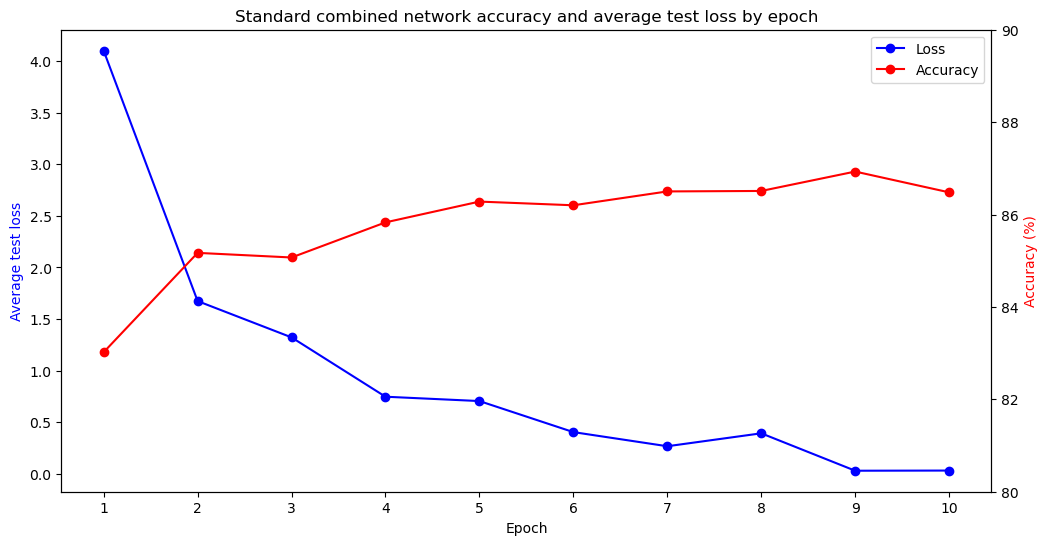

In [47]:
plot_metrics("Standard combined network", combined_losses, combined_accuracies)

### Autoencoder image transformations

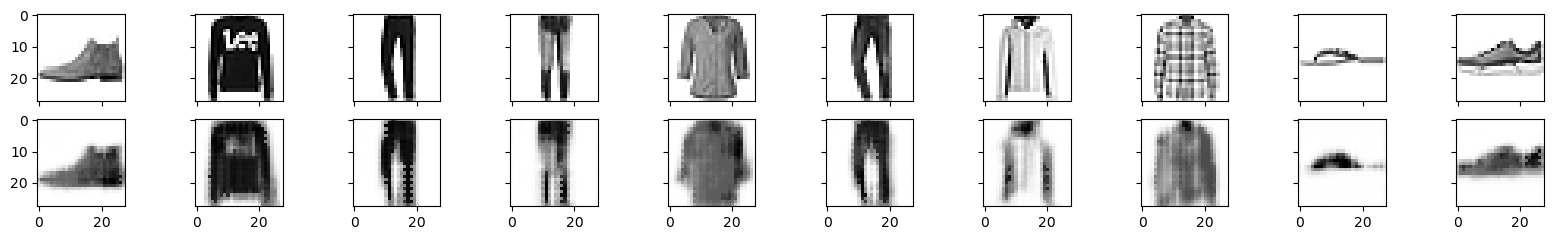

In [43]:
show_images(combined_base_model)

## 2: Parameter optimisation

I will investigate the following parameters:

* **Model types**: I will try adding a convolutional layer, removing a convolutional layer and adding a connected layer (there is currently only one)
* **Gamma values**: The default is 0.5 (half encoder, half classifier) but I will also try values of 0.3 (70% classifier) and 0.7 (70% autoencoder)
* **Batch sizes**: The default is 64, I will also try 16, 32 and 128
* **Dropout levels**: The default is 0.5 (50%), I will also try 0.3, 0.7 and 0.9
* **Pooling types**: The default is max pooling, I will also try using the average and the L2 norm
* **Activation functions**: The default is leaky ReLU, I will also try standard ReLU, sigmoid and tanh

Due to running time constraints and the results of the last optimisation, I will no longer investigate number of epochs and instead use a default of 10.

Baseline accuracy: 86.48%
Param layers: Value add_conv has Accuracy 85.03
Param layers: Value remove_conv has Accuracy 85.98
Param layers: Value add_connected has Accuracy 85.83
Best layers value: standard with accuracy 86.48%


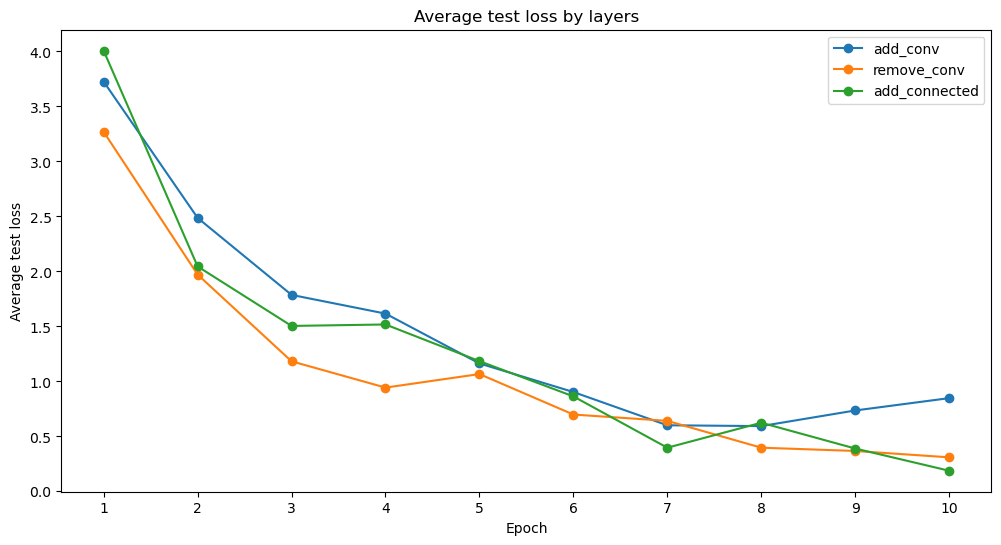

Baseline accuracy: 86.48%
Param gamma: Value 0.3 has Accuracy 87.60
Param gamma: Value 0.7 has Accuracy 86.79
Best gamma value: 0.3 with accuracy 87.6%


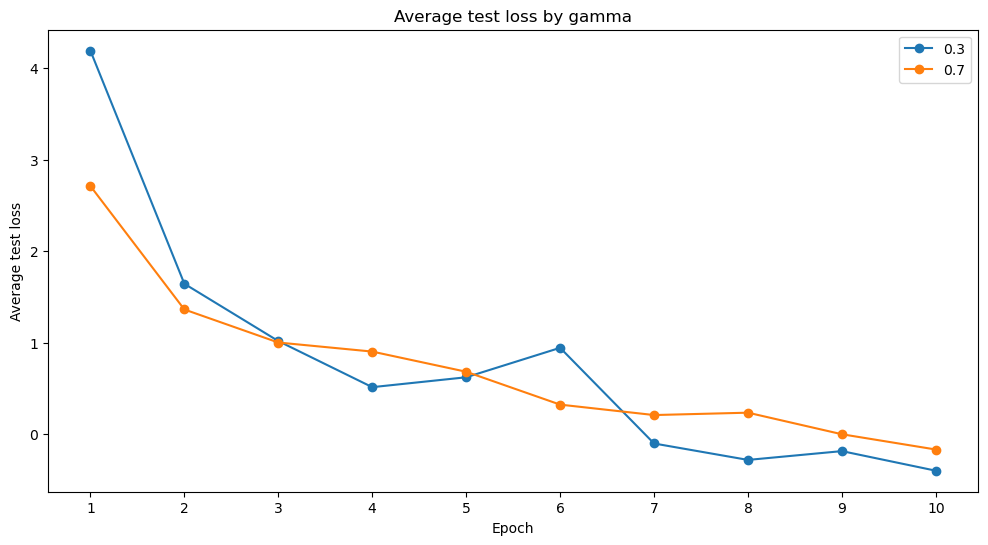

Baseline accuracy: 87.60%
Param batch_size: Value 16 has Accuracy 86.55
Param batch_size: Value 32 has Accuracy 87.83
Param batch_size: Value 128 has Accuracy 86.77
Best batch_size value: 32 with accuracy 87.83%


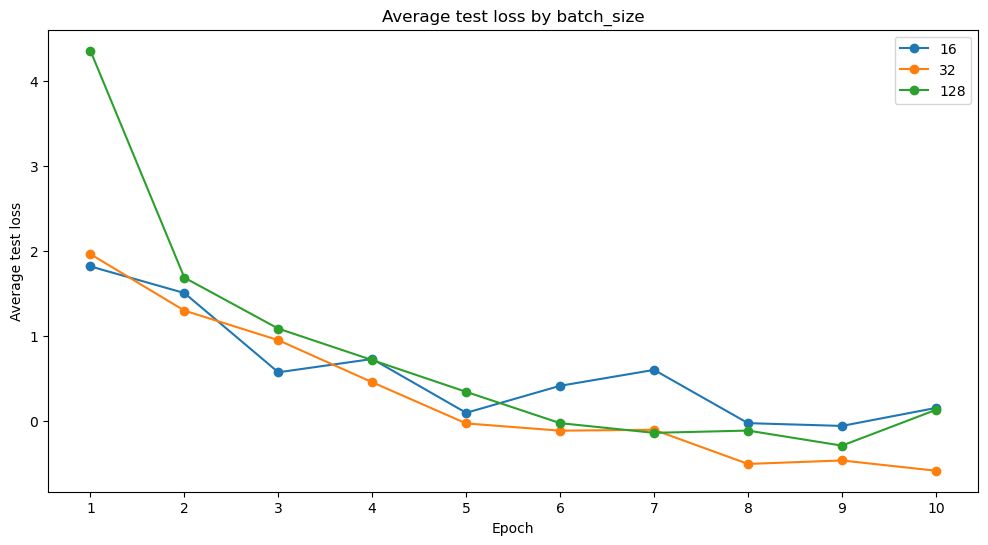

Baseline accuracy: 87.83%
Param dropout: Value 0.3 has Accuracy 86.71
Param dropout: Value 0.7 has Accuracy 84.69
Param dropout: Value 0.9 has Accuracy 80.96
Best dropout value: 0.5 with accuracy 87.83%


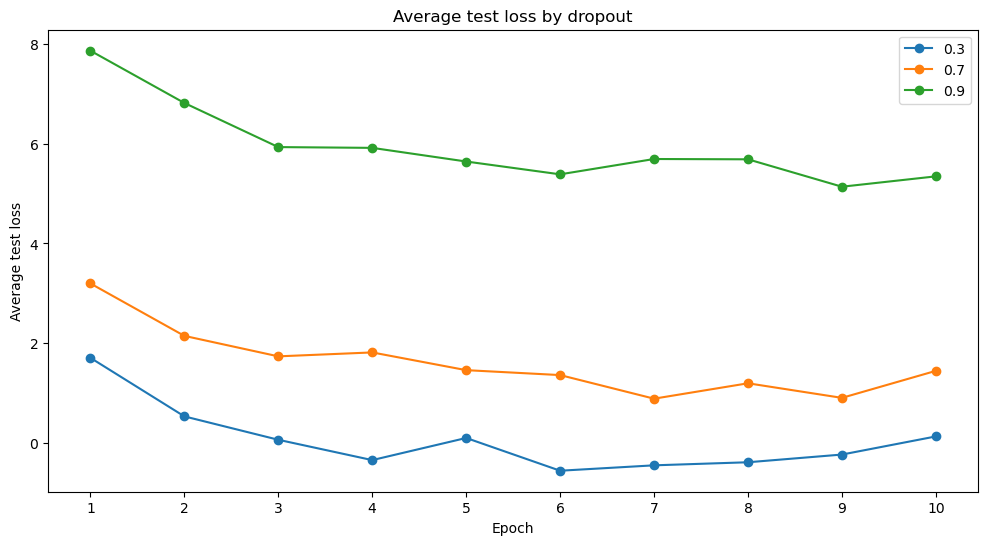

Baseline accuracy: 87.83%
Param pooling: Value average has Accuracy 87.57
Param pooling: Value l2 has Accuracy 87.37
Best pooling value: max with accuracy 87.83%


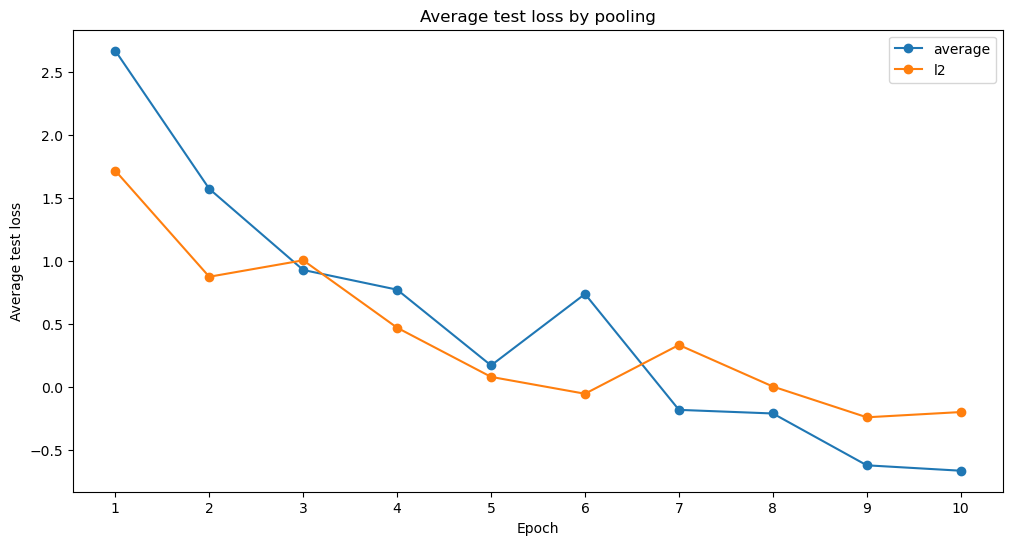

Baseline accuracy: 87.83%
Param activation: Value relu has Accuracy 87.57
Param activation: Value sigmoid has Accuracy 85.72
Param activation: Value tanh has Accuracy 86.22
Best activation value: leaky_relu with accuracy 87.83%


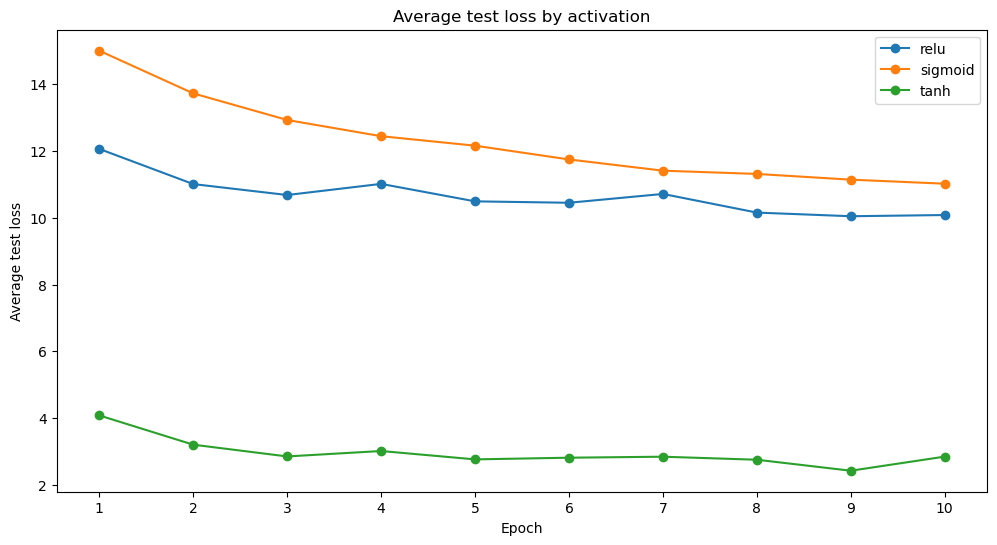

{'learning_rate': 0.005, 'batch_size': 32, 'num_epochs': 10, 'dropout': 0.5, 'layers': 'standard', 'pooling': 'max', 'activation': 'leaky_relu', 'gamma': 0.3}


In [70]:
current_combined_hparams = default_combined_hparams.copy()
layers = ["add_conv", "remove_conv", "add_connected"]
gammas = [0.3, 0.7]
batch_sizes = [16, 32, 128]
drop_outs = [0.3, 0.7, 0.9]
poolings = ["average", "l2"]
activations = ["relu", "sigmoid", "tanh"]


combined_hparams = {"layers": layers,
          "gamma": gammas,
          "batch_size": batch_sizes,
          "dropout": drop_outs,
          "pooling": poolings,
          "activation": activations}

baseline_accuracy = combined_accuracies[-1]

combined_best_model, combined_best_losses, combined_best_accuracies, best_combined_hparams = parameter_search(combined_base_model, combined_losses, current_combined_hparams, baseline_accuracy, combined_hparams, train_combined, True, combined_accuracies)
print(best_combined_hparams)

#### Best parameters found:
   * Best model variant: *Standard model*
   * Best gamma: *0.3 (70% classifier)*
   * Best batch size: *32*
   * Best dropout level: *0.5*
   * Best pooling type: *Max*
   * Best activation function: *Leaky ReLU*

## Results

### Base vs optimised combined models

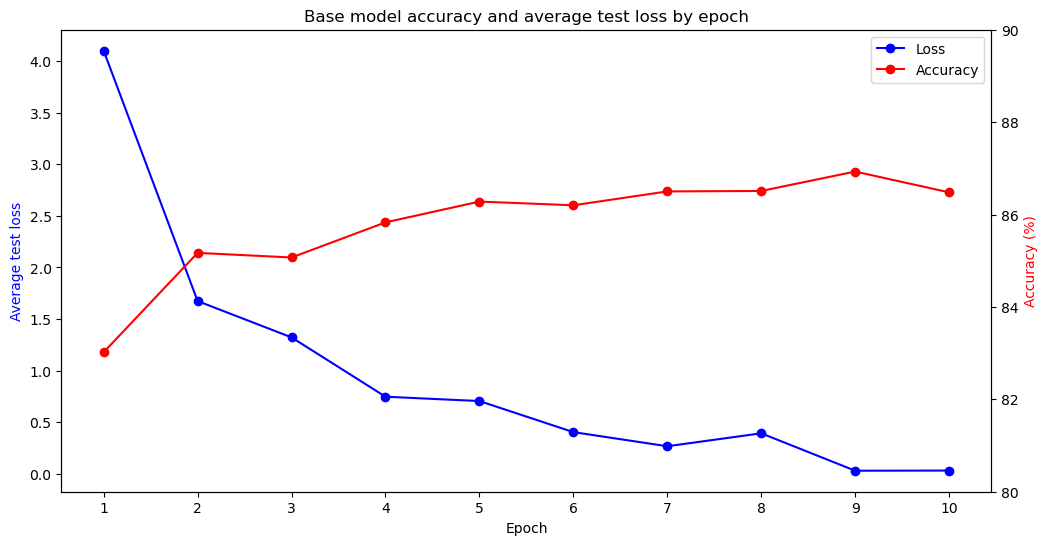

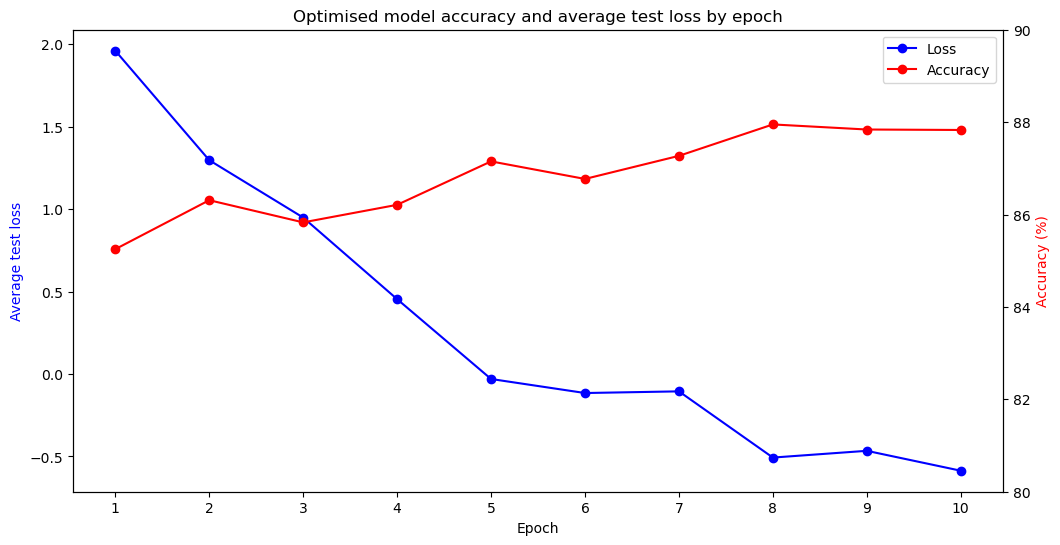

In [86]:
# Base and best model accuracies and losses
plot_metrics("Base model", combined_losses, combined_accuracies)
plot_metrics("Optimised model", combined_best_losses, combined_best_accuracies)

### 3: Combined vs solo (pure classifier and pure decoder) models

In [78]:
#Train individual classifier and encoder models
solo_classifier, solo_c_losses, solo_c_accuracies = train_combined(best_combined_hparams, gamma=0.0, silent=True)
solo_encoder, solo_e_losses, _ = train_combined(best_combined_hparams, gamma=1.0, silent=True)

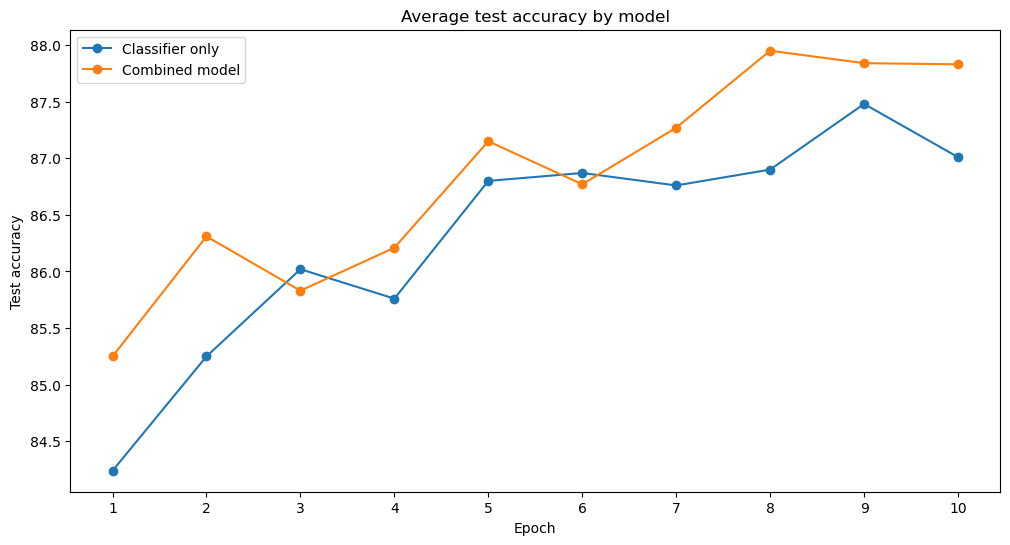

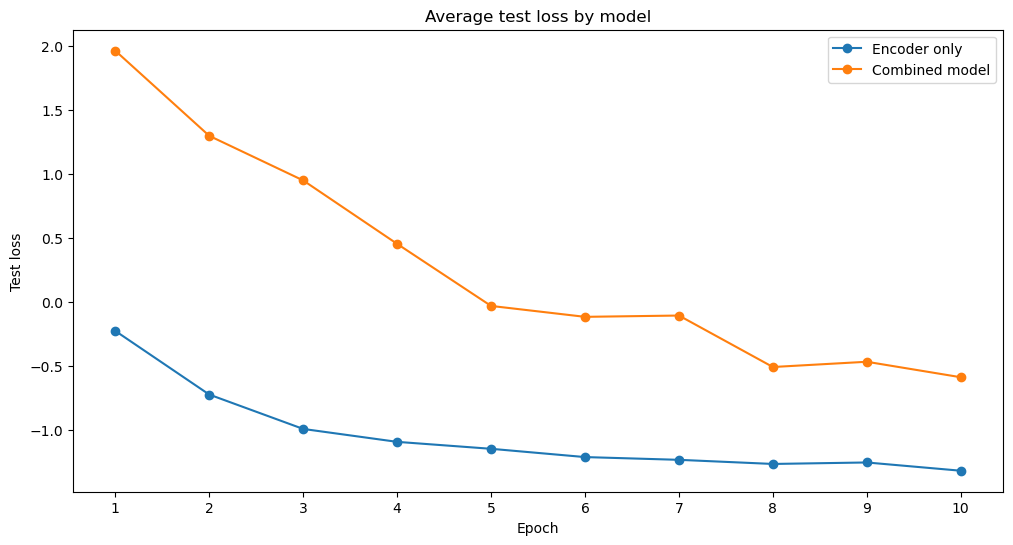

In [89]:
# Compare combined best to solo classifier
model_dict = {"Classifier only": solo_c_accuracies,
             "Combined model": combined_best_accuracies}

plot_compared_accuracy(model_dict)

# Compare combined best to solo encoder
model_dict = {"Encoder only": solo_e_losses,
             "Combined model": combined_best_losses}

plot_compared_loss(model_dict)

### Optimised combined image transformations

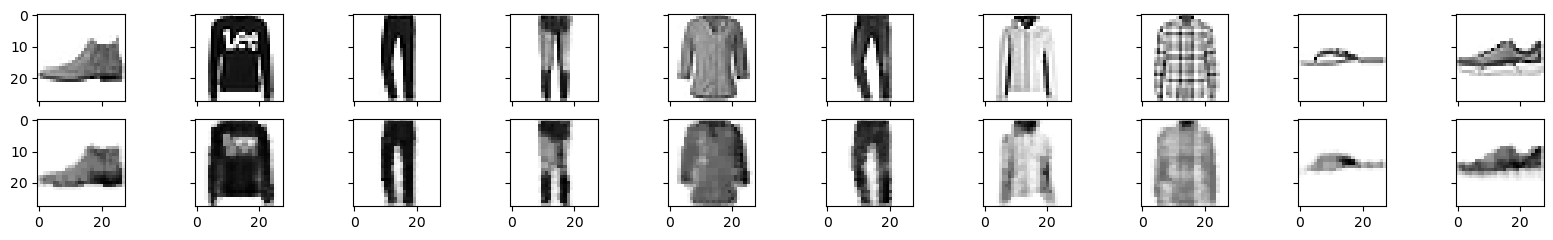

In [98]:
# Show solo autoencoder model images
show_images(solo_encoder)

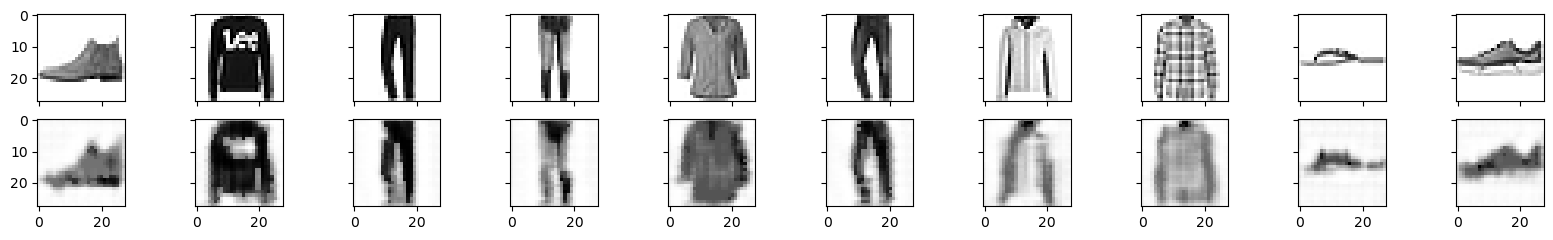

In [84]:
# Show optimised combinedmodel images
show_images(combined_best_model)

## Interpretation

I chose to train on accuracy instead of loss, as the combined loss may be overpowered by one loss or another, despite attempts to normalise. This means that a higher classifier percentage is favoured, as the task is the same as previously so optimising the classifier will do much more to improve accuracy than the autoencoder. This also explains why the new accuracy found (87.83%) is less than the pure classifier model of phase 1 (89.33%), as we are not fully optimising for classification accuracy in the new combined model. In the next 2 phases, I will try this model on tasks where creating a more general image representation (and thus minimising the autoencoder loss) should be more important (denoising and dethresholding). 

The solo encoder with the software switch enabled (decoder and classifier) performs better than the combined model on encoding an image (provides more accurate reconstructions) but the classifier accuracy is helped by adding some weight to the autoencoder losses (combined model performs better than the sole classifier). This could be because a more general representation of the image space helps to classify a given image. When image reconstruction becomes more difficult (due to corruption of training images), then improved autoencoder performance and higher autoencoder weighting (higher γ) may also increase classifier accuracy (better denoising will make it easier to classify a denoised image).

## Phase 3: Denoiser

### 1A-B: Preparing to train

I modified the combined model training function by adding noise to the training images before putting them through the model, and comparing the model output of the decoder to the uncorrupted noise image, thus teaching the model to convert the noised images to the normal images (denoise)

In [48]:
def add_noise(images, magnitude):
    noise = torch.randn_like(images) * magnitude
    return torch.clip((images + noise), 0, 1)

In [44]:
def denoiser_epoch(model, device, train_loader, optimizer, epoch, gamma, noise_fn, silent=False):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        noisy_features = noise_fn(features)
        noisy_features = noisy_features.to(device)
        features = features.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        ### FORWARD AND BACK PROP
        c, d = model(noisy_features)
        loss = combined_loss(c, d, features, targets, gamma)
        loss.backward()
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        ### LOGGING
        if not silent and batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(features), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

def test_denoiser(model, device, test_loader, gamma, noise_fn, silent=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for features, targets in test_loader:
            noisy_features = noise_fn(features)
            noisy_features = noisy_features.to(device)
            features, targets = features.to(device), targets.to(device)
            output, decoded = model(noisy_features)
            test_loss += combined_test_loss(output, decoded, features, targets, gamma) # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader)
    accuracy = (100. * correct / len(test_loader.dataset))
    
    if not silent:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            accuracy))
    return test_loss, accuracy

def train_denoiser(hparams, noise_fn, gamma=None, silent=False):

    num_epochs = hparams["num_epochs"]
    batch_size = hparams["batch_size"]
    learning_rate = hparams["learning_rate"]
    if gamma is None:
        gamma = hparams["gamma"]
    # Normalise gamma
    gamma = max(min(gamma, 1.0), 0.0)
    
    train_loader = torch.utils.data.DataLoader(dataset=datasets.FashionMNIST(root='data', 
                                train=True, 
                                transform=transforms.ToTensor(),
                                download=True), 
                            batch_size=batch_size, 
                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=datasets.FashionMNIST(root='data', 
                                train=False, 
                                transform=transforms.ToTensor(),
                                download=True), 
                            batch_size=batch_size, 
                            shuffle=False)

    models = {"standard": Combined,
             "add_conv": Combined_addconv,
             "remove_conv": Combined_removeconv,
             "add_connected": Combined_addconnected}

    model = models[hparams["layers"]](hparams).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(1, num_epochs + 1):
        denoiser_epoch(model, device, train_loader, optimizer, epoch, gamma, noise_fn, silent=silent)
        epoch_loss, epoch_accuracy = test_denoiser(model, device, test_loader, gamma, noise_fn, silent=silent)
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

    return (model, epoch_losses, epoch_accuracies)

## Training at 3 different noise levels

I ran an experiment to see the accuracy/loss of the combined denoising model at 3 levels of noise: 1%, 5% and 10% magnitude

In [71]:
# Train at 3 different noise magnitudes
for magnitude in [0.01, 0.1, 0.05]:
    noise_fn = lambda x: add_noise(x, magnitude)
    denoiser_base_model, denoiser_losses, denoiser_accuracies = train_denoiser(default_combined_hparams, noise_fn, silent=True)
    print(f"Standard denoiser accuracy at {magnitude*100}% noise: {denoiser_accuracies[-1]:0.2f}%")
    print(f"Standard denoiser loss at {magnitude*100}% noise: {denoiser_losses[-1]:0.4f}")

Standard denoiser accuracy at 1.0% noise: 86.70%
Standard denoiser loss at 1.0% noise: -0.0135
Standard denoiser accuracy at 10.0% noise: 86.08%
Standard denoiser loss at 10.0% noise: 0.3853
Standard denoiser accuracy at 5.0% noise: 86.51%
Standard denoiser loss at 5.0% noise: 0.4607


As expected, at higher magnitudes of noise the model has a worse performance removing the noise and classifying the final image. This is likely because as more of the original image is corrupted, and thus reconstruction is more difficult, it is harder to accurately estimate the original images for thousands of training items.

### Denoiser image transformations (at 5% magnitude)

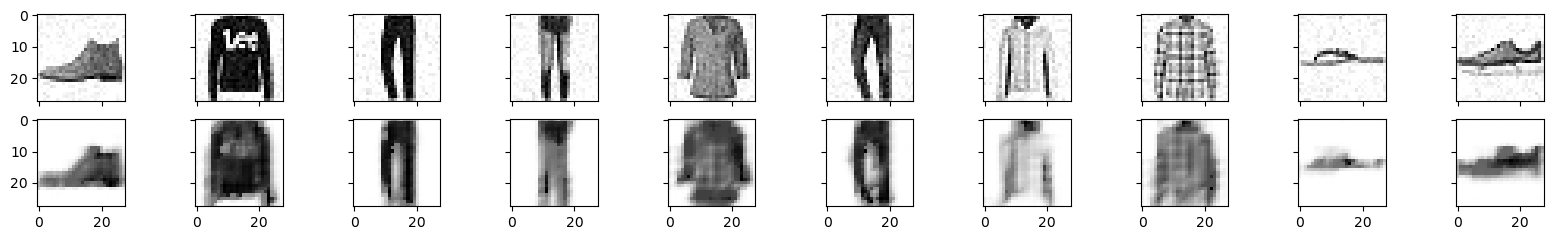

In [83]:
# Show image transformations
show_noisy_images(denoiser_base_model, noise_fn)

## 1C: Parameter optimisation

I will investigate the following parameters:

* **Model types**: I will try adding a convolutional layer, removing a convolutional layer and adding a connected layer (there is currently only one)
* **Gamma values**: The default is 0.5 (half encoder, half classifier) but I will also try values of 0.3 (70% classifier) and 0.7 (70% autoencoder) to see if changing the balance will improve the models ability to denoise
* **Batch sizes**: The default is 64, I will also try 16, 32 and 128
* **Dropout levels**: The default is 0.5 (50%), I will also try 0.3, 0.7 and 0.9
* **Pooling types**: The default is max pooling, I will also try using the average and the L2 norm
* **Activation functions**: The default is leaky ReLU, I will also try standard ReLU, sigmoid and tanh

I am choosing to optimise the denoiser at 5% noise as it is a good balance (1% is too little to make a significant difference to performance, 10% is too much to reliably denoise with as strong performance)

Baseline accuracy: 86.51%
Param layers: Value add_conv has Accuracy 85.58
Param layers: Value remove_conv has Accuracy 84.55
Param layers: Value add_connected has Accuracy 85.57
Best layers value: standard with accuracy 86.51%


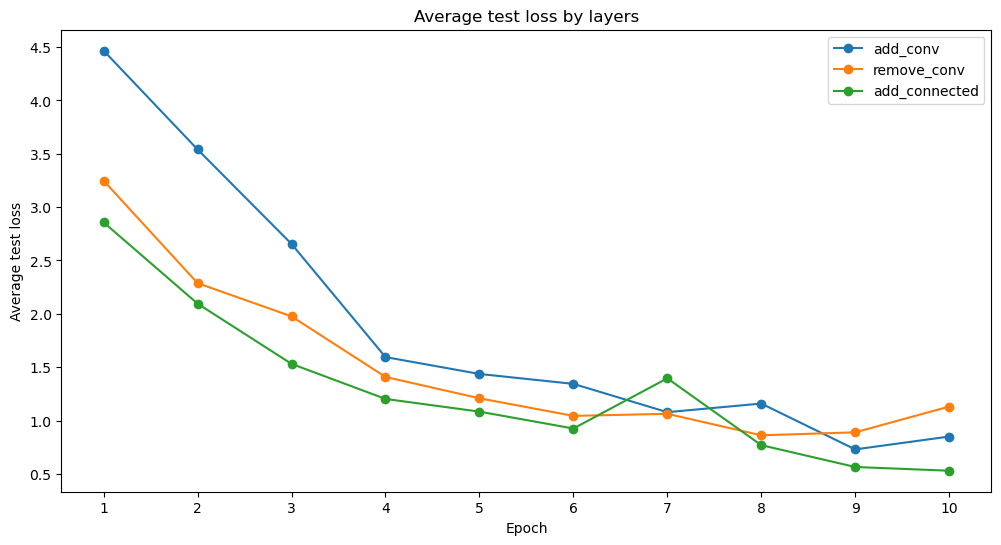

Baseline accuracy: 86.51%
Param gamma: Value 0.3 has Accuracy 86.74
Param gamma: Value 0.7 has Accuracy 85.94
Best gamma value: 0.3 with accuracy 86.74%


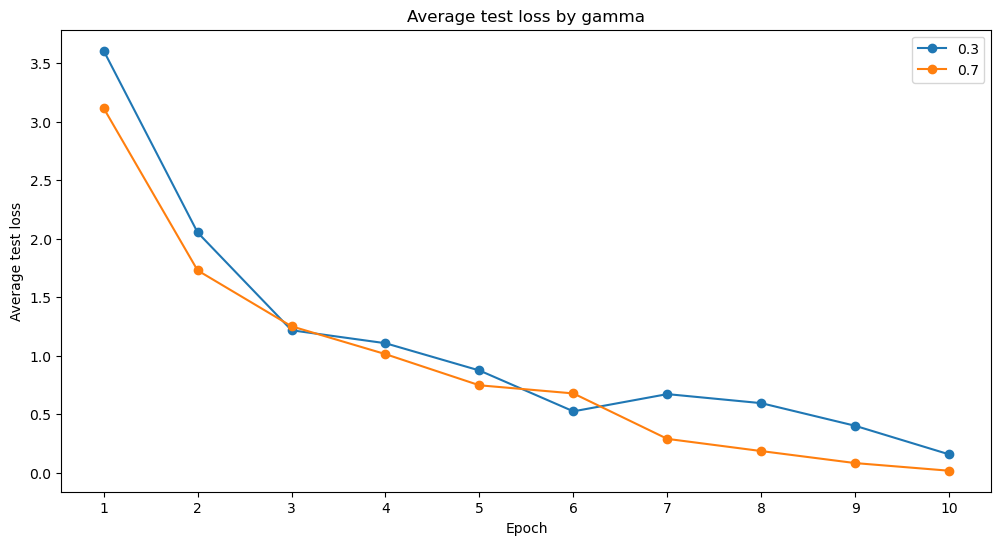

Baseline accuracy: 86.74%
Param batch_size: Value 16 has Accuracy 86.64
Param batch_size: Value 32 has Accuracy 85.73
Param batch_size: Value 128 has Accuracy 86.63
Best batch_size value: 64 with accuracy 86.74%


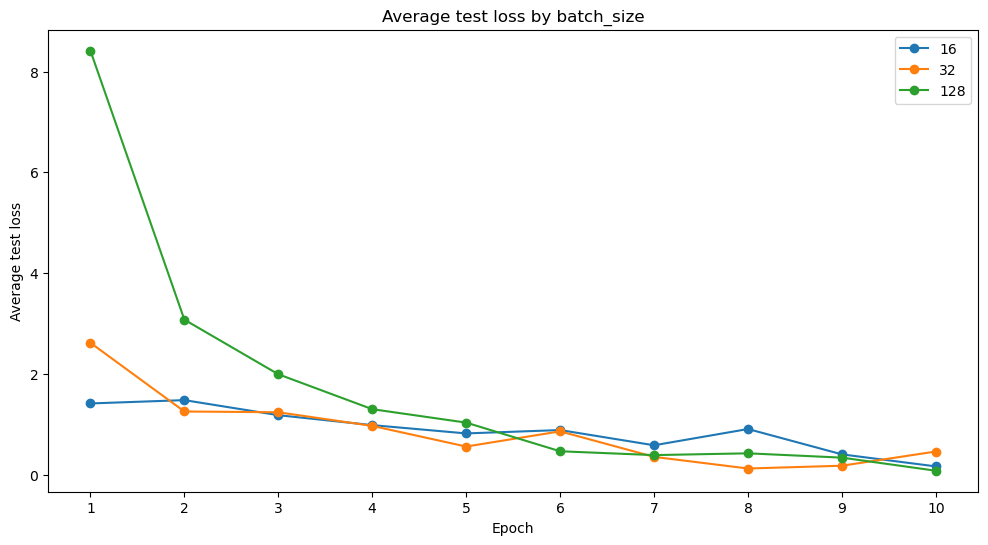

Baseline accuracy: 86.74%
Param dropout: Value 0.3 has Accuracy 87.45
Param dropout: Value 0.7 has Accuracy 84.93
Param dropout: Value 0.9 has Accuracy 79.87
Best dropout value: 0.3 with accuracy 87.45%


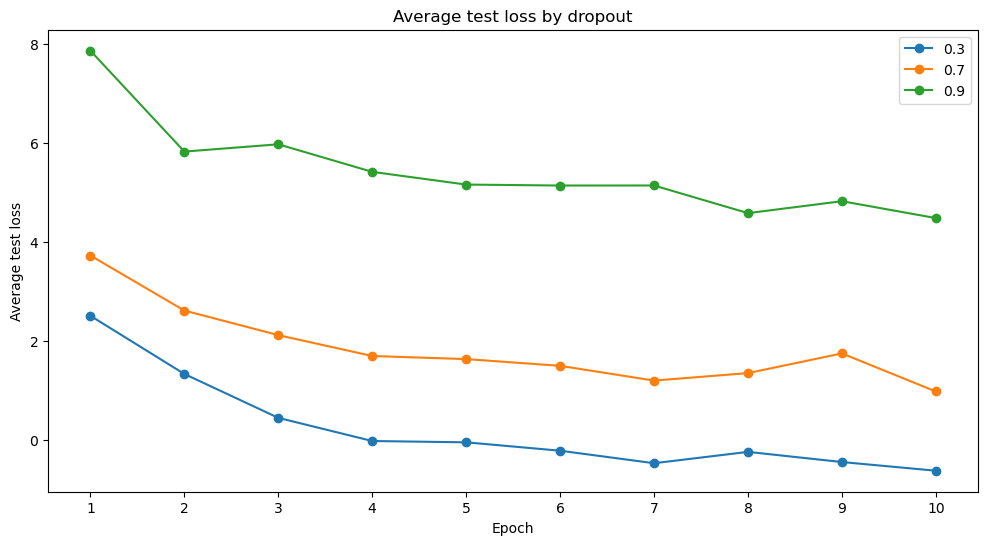

Baseline accuracy: 87.45%
Param pooling: Value average has Accuracy 87.91
Param pooling: Value l2 has Accuracy 87.29
Best pooling value: average with accuracy 87.91%


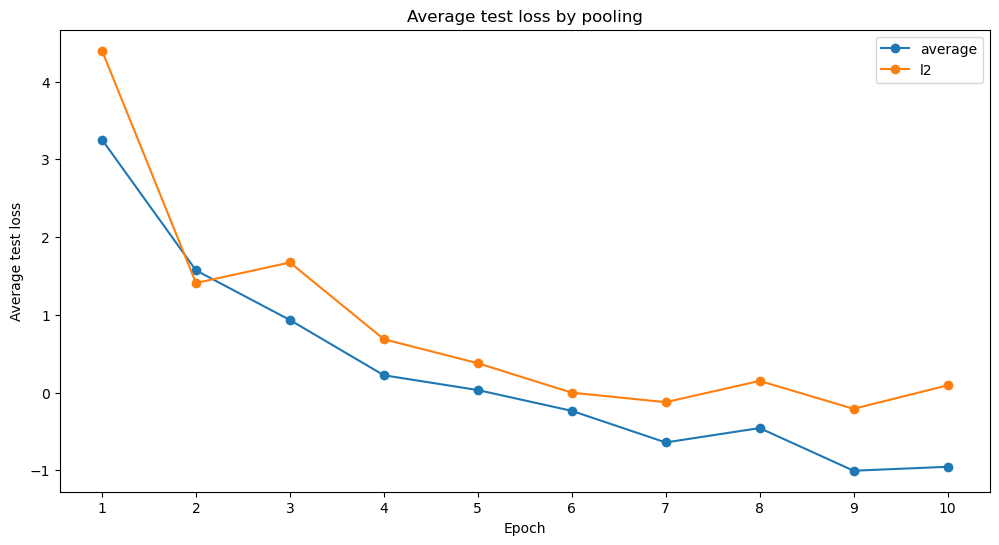

Baseline accuracy: 87.91%
Param activation: Value relu has Accuracy 87.68
Param activation: Value sigmoid has Accuracy 85.58
Param activation: Value tanh has Accuracy 86.49
Best activation value: leaky_relu with accuracy 87.91%


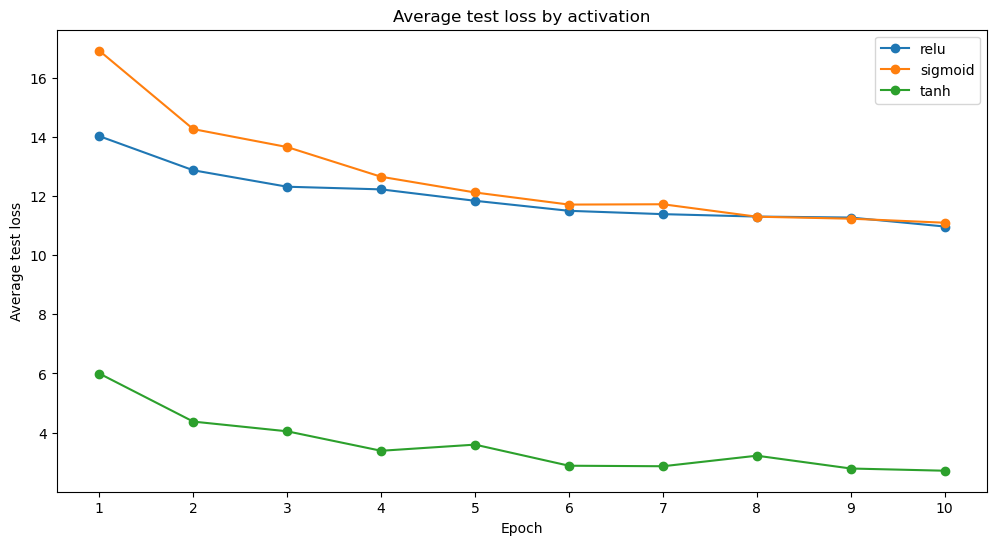

{'learning_rate': 0.005, 'batch_size': 64, 'num_epochs': 10, 'dropout': 0.3, 'layers': 'standard', 'pooling': 'average', 'activation': 'leaky_relu', 'gamma': 0.3}


In [90]:
# Optimise at 5% noise
current_denoiser_hparams = default_combined_hparams.copy()
layers = ["add_conv", "remove_conv", "add_connected"]
gammas = [0.3, 0.7]
batch_sizes = [16, 32, 128]
drop_outs = [0.3, 0.7, 0.9]
poolings = ["average", "l2"]
activations = ["relu", "sigmoid", "tanh"]


denoiser_hparams = {"layers": layers,
          "gamma": gammas,
          "batch_size": batch_sizes,
          "dropout": drop_outs,
          "pooling": poolings,
          "activation": activations}

baseline_accuracy = denoiser_accuracies[-1]


noise_fn = lambda x: add_noise(x, 0.05)
train_func = lambda x, silent: train_denoiser(x, noise_fn, silent=silent)

denoiser_best_model, denoiser_best_losses, denoiser_best_accuracies, best_denoiser_hparams = parameter_search(denoiser_base_model, denoiser_losses, current_denoiser_hparams, baseline_accuracy, denoiser_hparams, train_func, True, denoiser_accuracies)
print(best_denoiser_hparams)

#### Best parameters found:
   * Best model variant: *Standard*
   * Best gamma: *0.3 (70% classifier)*
   * Best batch size: *32*
   * Best droout level: *0.3*
   * Best pooling type: *Average*
   * Best activation function: *Leaky ReLU*

## 1D: Results

### Optimised denoiser image transformations

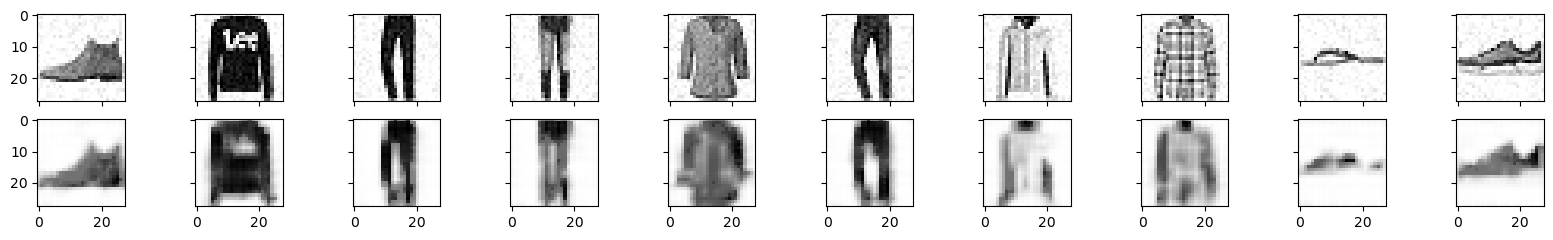

In [91]:
# Show image transformations
show_noisy_images(denoiser_best_model, noise_fn)

### Base vs optimised denoiser

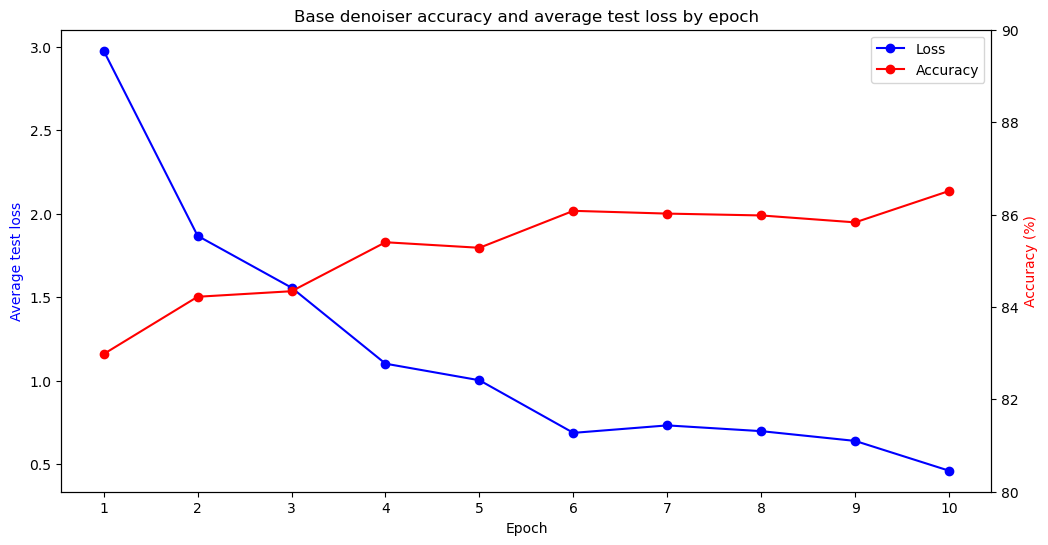

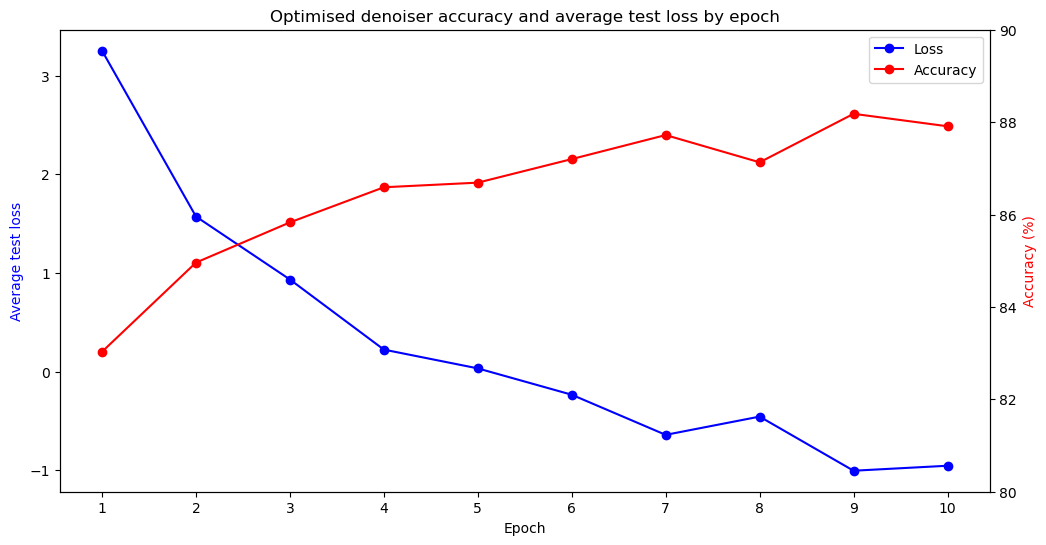

In [93]:
# Plot baseline and best denoiser at 5% noise
plot_metrics("Base denoiser", denoiser_losses, denoiser_accuracies)
plot_metrics("Optimised denoiser", denoiser_best_losses, denoiser_best_accuracies)

## 1E: Interpretation

Because the denoiser is optimising both the classification of fashion items and the ability to remove noise from the corrupted original images, despite only a small increase in classification accuracy, the loss is largely decreased in the optimised system. This is shown in the images, where the optimised model does a better job at isolating the main fashion items from the noise. While the model still favours a more heavily weighted classification loss, the increase in efficiency is far less than in the combined model without denoising, suggesting the autoencoder is more important in this example for improving classifications. I will investigate whether the dethresholding model prefers 50% or even 70% autoencoder loss weighting on a transformation which is more corrupting (binary thresholding).

## Phase 4: Binary unthresholding network

### Preparing to train

I have chosen to train a network to both classify and reverse binary thresholding (for all values above a tolerance, set to 1. For all values below or equal, set to 0). I chose this as these thresholds can easily be generated from the training data and I would like to investigate how robust the model can be in both reversing a thresholding and correctly classifying the fashion data which is binary. To train the model, I give it the thresholded data and train the autoencoder on MSE loss from the original version of the same image (classifier remains unchanged, but uses thresholded data). Ican reuse the code from the denoiser, but change the noise function to a binary thresholder.

In [52]:
def threshold(images, t=0.5):
    thresholded = torch.zeros_like(images)
    thresholded[torch.where(images>t)] = 1
    return thresholded

## Training at 3 different threshold levels

I ran an experiment to see the accuracy/loss of the combined denoising model at 3 levels of threshold: 0.3, 0.5 and 0.7

In [75]:
for t in [0.3, 0.7, 0.5]:
    noise_fn = lambda x: threshold(x, t)
    thresholder_base_model, thresholder_losses, thresholder_accuracies = train_denoiser(default_combined_hparams, noise_fn, silent=True)
    print(f"Standard thresholder accuracy at t={t}: {thresholder_accuracies[-1]:0.2f}%")
    print(f"Standard thresholder loss at t={t}: {thresholder_losses[-1]:0.4f}")

Standard thresholder accuracy at t=0.3: 84.06%
Standard thresholder loss at t=0.3: 2.1538
Standard thresholder accuracy at t=0.7: 77.53%
Standard thresholder loss at t=0.7: 6.3308
Standard thresholder accuracy at t=0.5: 82.80%
Standard thresholder loss at t=0.5: 3.0686


It seems that the best performance for the system is t=0.3 (anything above 0.3 is black, everything else is white). The model suffers quite dramatically at t=0.7, which suggests at this threshold a lot of the original image is lost and reconstruction is far more difficult.

### Thresholder image transformations (at t = 0.5)

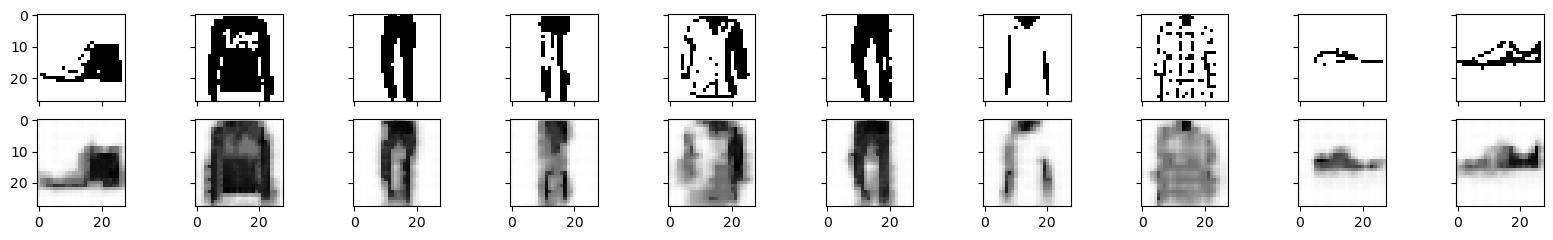

In [76]:
# Show image transformations
show_noisy_images(thresholder_base_model, threshold)

## Parameter optimisation

I will investigate the following parameters:

* **Model types**: I will try adding a convolutional layer, removing a convolutional layer and adding a connected layer (there is currently only one)
* **Gamma values**: The default is 0.5 (half encoder, half classifier) but I will also try values of 0.3 (70% classifier) and 0.7 (70% autoencoder) to see if the balance may help the network threshold the images
* **Batch sizes**: The default is 64, I will also try 16, 32 and 128
* **Dropout levels**: The default is 0.5 (50%), I will also try 0.3, 0.7 and 0.9
* **Pooling types**: The default is max pooling, I will also try using the average and the L2 norm
* **Activation functions**: The default is leaky ReLU, I will also try standard ReLU, sigmoid and tanh

I am choosing to optimise the dethresholder at t = 0.5 as it is the best rough thresholding I have observed (no value of binary thresholding is perfect to threshold each fashion item)

Baseline accuracy: 82.80%
Param layers: Value add_conv has Accuracy 81.80
Param layers: Value remove_conv has Accuracy 80.61
Param layers: Value add_connected has Accuracy 81.65
Best layers value: standard with accuracy 82.8%


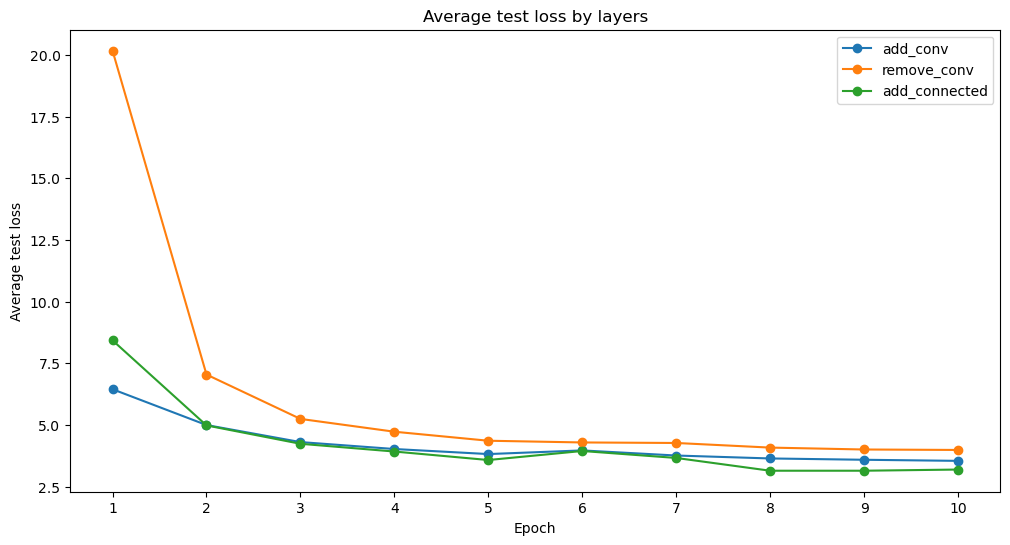

Baseline accuracy: 82.80%
Param gamma: Value 0.3 has Accuracy 82.23
Param gamma: Value 0.7 has Accuracy 81.80
Best gamma value: 0.5 with accuracy 82.8%


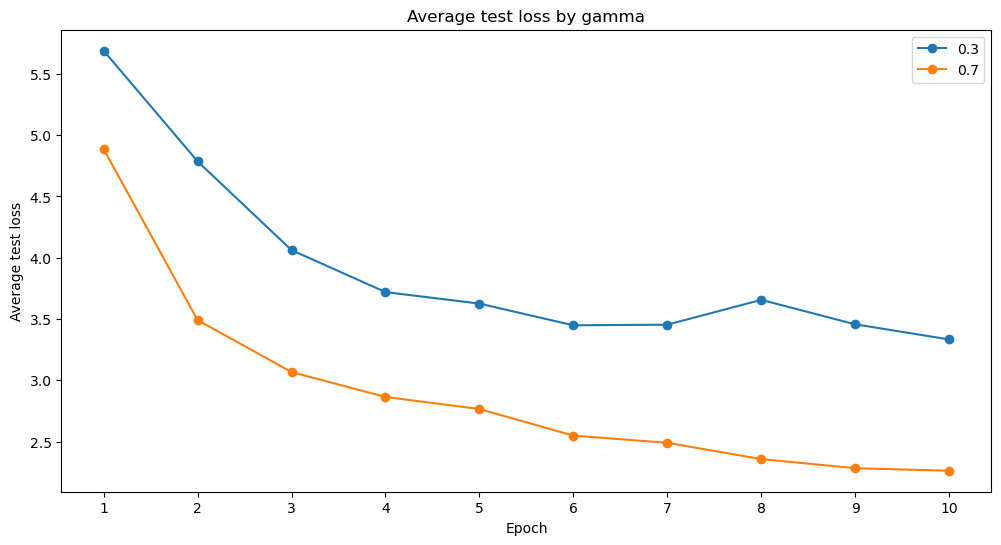

Baseline accuracy: 82.80%
Param batch_size: Value 16 has Accuracy 82.27
Param batch_size: Value 32 has Accuracy 82.14
Param batch_size: Value 128 has Accuracy 83.06
Best batch_size value: 128 with accuracy 83.06%


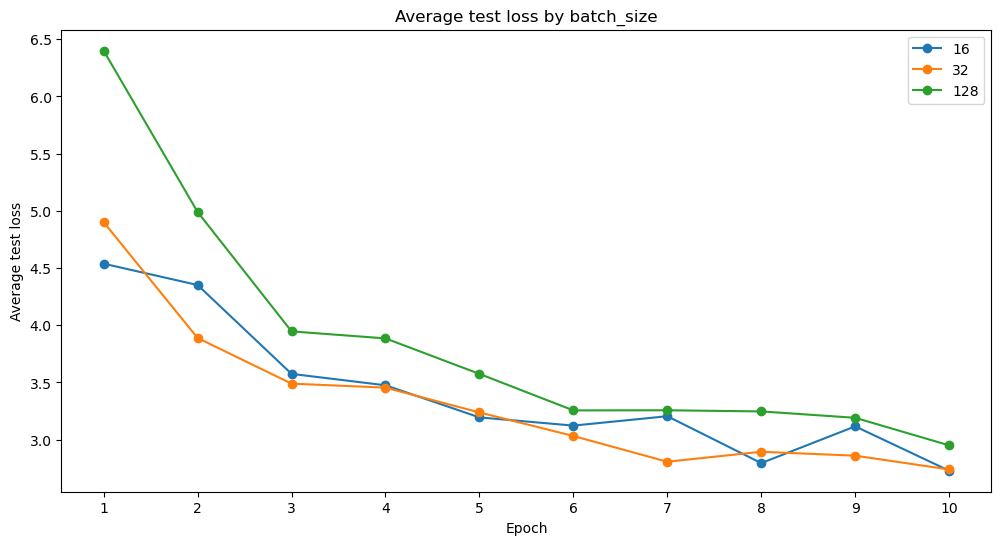

Baseline accuracy: 83.06%
Param dropout: Value 0.3 has Accuracy 82.98
Param dropout: Value 0.7 has Accuracy 81.02
Param dropout: Value 0.9 has Accuracy 76.39
Best dropout value: 0.5 with accuracy 83.06%


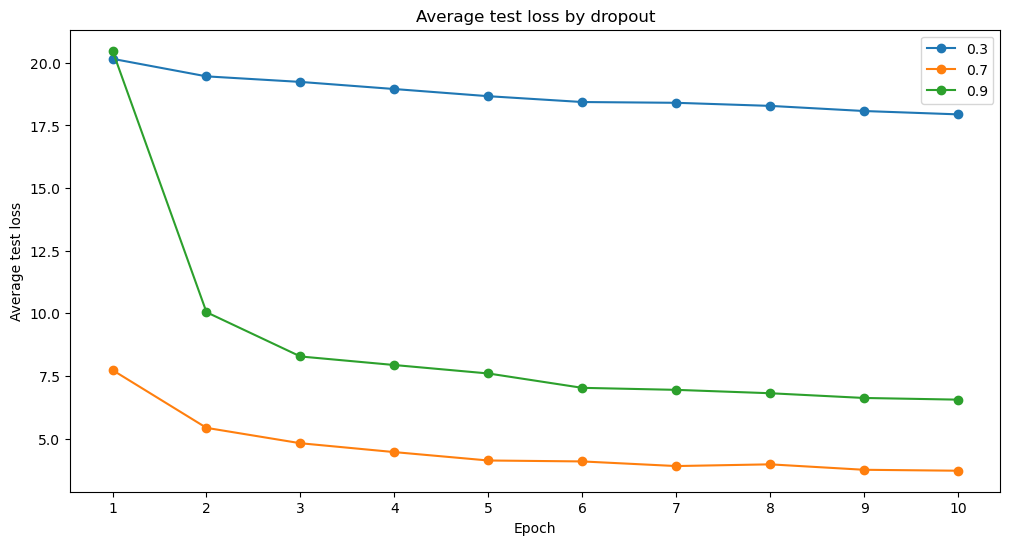

Baseline accuracy: 83.06%
Param pooling: Value average has Accuracy 82.30
Param pooling: Value l2 has Accuracy 81.40
Best pooling value: max with accuracy 83.06%


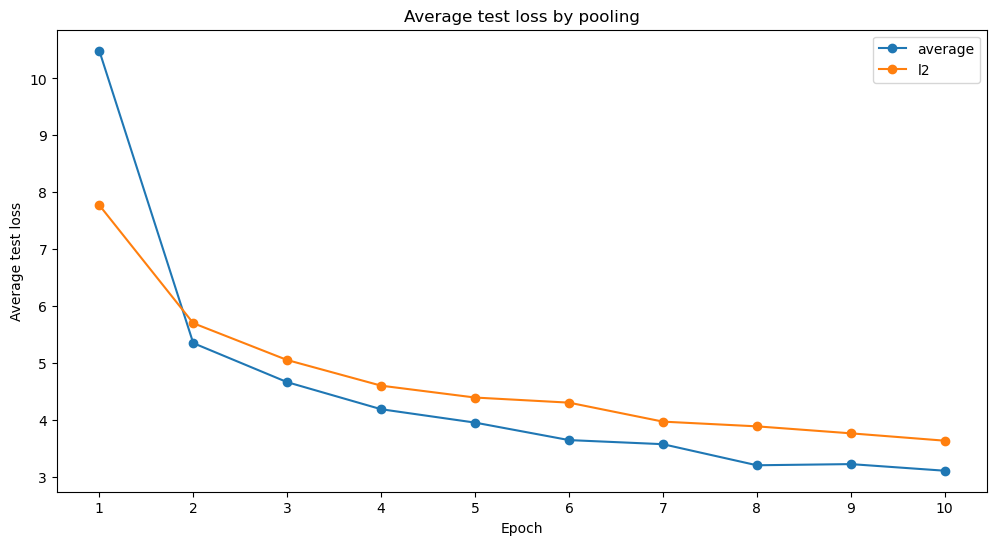

Baseline accuracy: 83.06%
Param activation: Value relu has Accuracy 82.56
Param activation: Value sigmoid has Accuracy 80.07
Param activation: Value tanh has Accuracy 82.60
Best activation value: leaky_relu with accuracy 83.06%


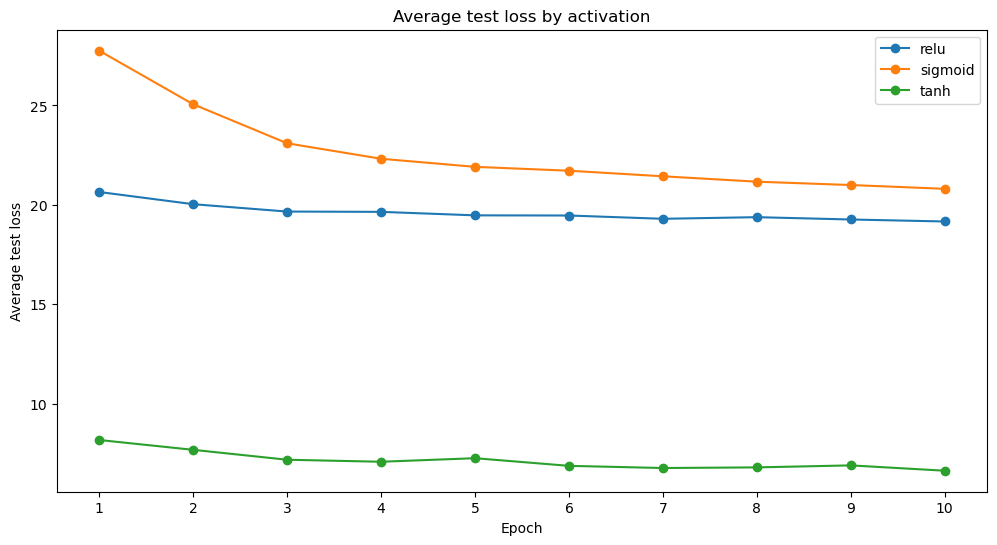

{'learning_rate': 0.005, 'batch_size': 128, 'num_epochs': 10, 'dropout': 0.5, 'layers': 'standard', 'pooling': 'max', 'activation': 'leaky_relu', 'gamma': 0.5}


In [95]:
current_thresholder_hparams = default_combined_hparams.copy()
layers = ["add_conv", "remove_conv", "add_connected"]
gammas = [0.3, 0.7]
batch_sizes = [16, 32, 128]
drop_outs = [0.3, 0.7, 0.9]
poolings = ["average", "l2"]
activations = ["relu", "sigmoid", "tanh"]


thresholder_hparams = {"layers": layers,
          "gamma": gammas,
          "batch_size": batch_sizes,
          "dropout": drop_outs,
          "pooling": poolings,
          "activation": activations}

baseline_accuracy = thresholder_accuracies[-1]

train_func = lambda x, silent: train_denoiser(x, threshold, silent=silent)

thresholder_best_model, thresholder_best_losses, thresholder_best_accuracies, best_thresholder_hparams = parameter_search(thresholder_base_model, thresholder_losses, current_thresholder_hparams, baseline_accuracy, thresholder_hparams, train_func, True, thresholder_accuracies)
print(best_thresholder_hparams)

#### Best parameters found:
   * Best model variant: *Standard model*
   * Best gamma: *0.5 (50% each loss type)*
   * Best batch size: *128*
   * Best dropout level: *0.5*
   * Best pooling type: *Max*
   * Best activation function: *Leaky ReLU*

## Results

### Optimised thresholder image transformations

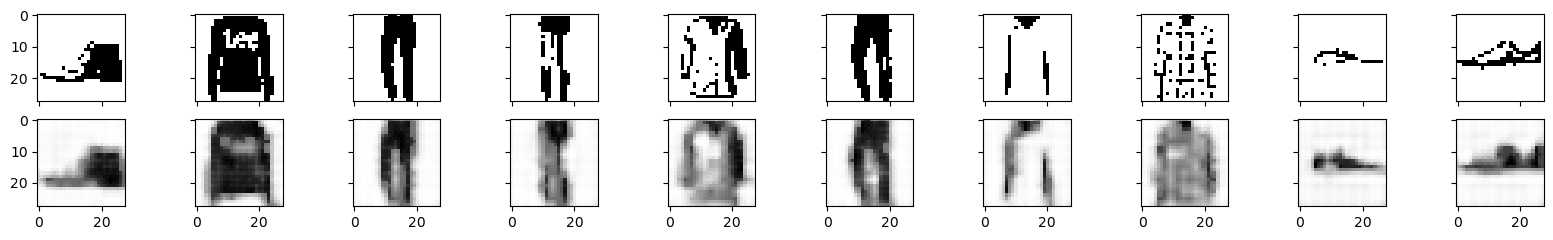

In [99]:
# Show image transformations
show_noisy_images(thresholder_best_model, threshold)

### Baseline vs optimised thresholder

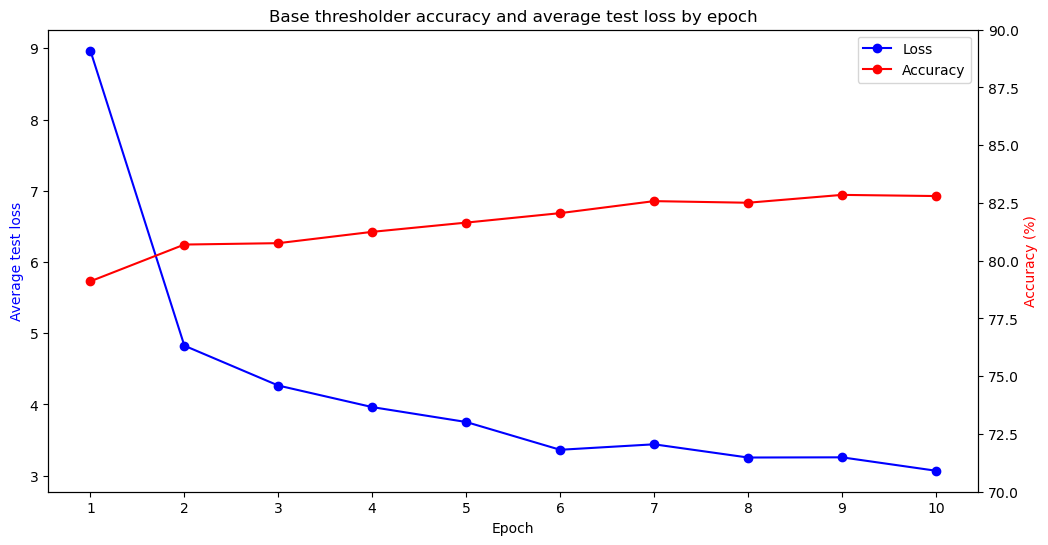

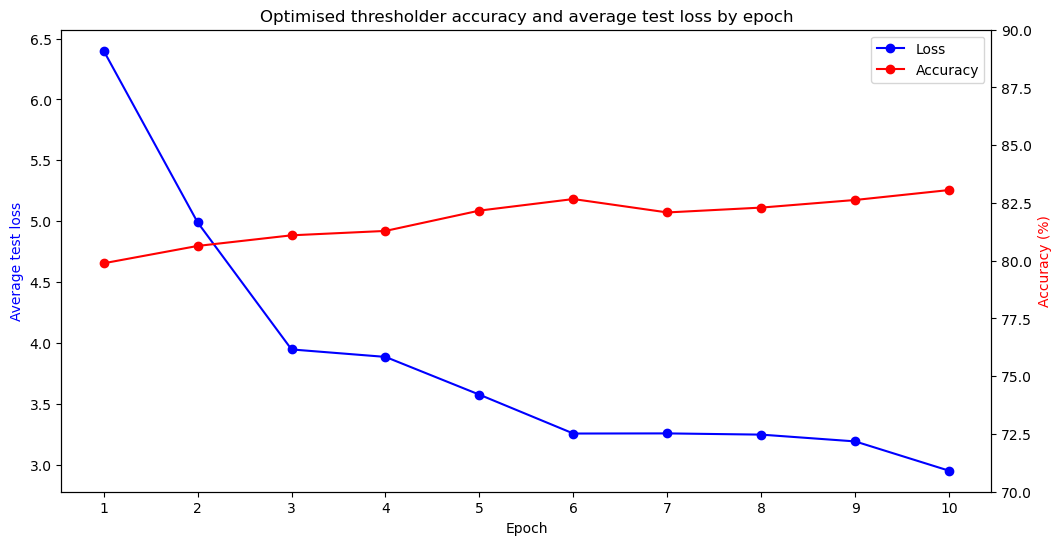

In [97]:
# Plot baseline and best thresholder
plot_metrics("Base thresholder", thresholder_losses, thresholder_accuracies)
plot_metrics("Optimised thresholder", thresholder_best_losses, thresholder_best_accuracies)

## Interpretation

The overall accuracy of the system is lower again, due to it being presented a more difficult task (binary thresholding is more destructive to the original image than adding noise as in phase 3). This time the autoencoder loss is more important to the overall model (with γ=0.5 finally being preferred over γ=0.3), I believe this is because reconstruction is more difficult and more important to classification (it was easier to classify a slightly noisy image than a binary thresholded one). 

The system showed very little improvement through optimisation. This may be because the task is too difficult or because a different model should be applied to it. With more time to run parameter optimisation, perhaps grid searching or searching of different parameters (learning rate, number of epochs etc) would provide more accuracy improvements.

It is worth noting that at 0.3 dropout, the model hardly learned anything (very minimal decrease in the loss). This may be bacause the model is overfitting as not enough parameters are zeroed out, and so despite increasing performance on the training data the results on the test data show little improvement.